### Second dataset

##### we can add Criteria 1, which identifies customers with a low account balance yet high frequency of spending, indicating potential financial stress. Criteria 2 targets customers who do not have a recorded income and exhibit high spending frequency; for these customers, offering financial advice could be beneficial.

#### data preprocessing

In [5]:
import pandas as pd
import seaborn as sb

df = pd.read_csv('/Users/thanaparleelasathapornkun/Library/Mobile Documents/com~apple~CloudDocs/Term2/dsmp-2024-group-30/fake_transactional_data_24.csv', encoding='utf-8')
df_NonNumeric_Mapping_1 = pd.read_excel('/Users/thanaparleelasathapornkun/Library/Mobile Documents/com~apple~CloudDocs/Term2/dsmp-2024-group-30/Location_value_pairs.xlsx')

df_NonNumeric_Mapping = pd.read_excel('/Users/thanaparleelasathapornkun/Library/Mobile Documents/com~apple~CloudDocs/Term2/dsmp-2024-group-30/Location_value_pairs_2.xlsx',sheet_name="seconddataset")
df_simulated_transaction_2024 = pd.read_csv("/Users/thanaparleelasathapornkun/Library/Mobile Documents/com~apple~CloudDocs/Term2/dsmp-2024-group-30/simulated_transaction_2024.csv", encoding='utf-8')


#### 1 dataset

In [6]:
df = df.rename(columns={"from_totally_fake_account": "AccountNumber", "monopoly_money_amount": "MoneyTransferAmount", "to_randomly_generated_account": "TransferredLocationAccount", "not_happened_yet_date": "TransactionDate"})

#non-numeric and numeric value
df_Transferred_numeric = df[df['TransferredLocationAccount'].apply(lambda x: str(x).isnumeric())].copy()
df_Transferred_Non_Numeric = df[df['TransferredLocationAccount'].apply(lambda x: str(x).isnumeric()==False)].copy()

print(df_NonNumeric_Mapping_1)
df_NonNumeric_Mapping_1['Key'] = df_NonNumeric_Mapping_1['Key'].str.strip()
mapping_dict = df_NonNumeric_Mapping_1.to_dict(orient='records')
mapped_dict = {entry['Key']: entry['Value'] for entry in mapping_dict}

# # Create a new column by mapping values from the 'key' column using the mapping dictionary
df_Transferred_Non_Numeric['CategoryTransferredLocationAccount'] = df_Transferred_Non_Numeric['TransferredLocationAccount'].map(mapped_dict)

# # Print the DataFrame with the new column
print(df_Transferred_Non_Numeric)
 
frames = [df_Transferred_Non_Numeric,df_Transferred_numeric]
df2 = pd.concat(frames)
df2['CategoryTransferredLocationAccount'].fillna('Numeric', inplace=True)

# Ensure TransactionDate is in datetime format
df2['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True)  # Adjusting for day-first format
end_date = pd.Timestamp('2025-12-31')

#find AVG money spend for each category for each customers
avg_spend = df2.groupby(['AccountNumber', 'CategoryTransferredLocationAccount'])['MoneyTransferAmount'].mean().reset_index()

#Identifying the category with the highest average spend for each customer
AccountNumber_highestAvgSpend_df = avg_spend.loc[avg_spend.groupby('AccountNumber')['MoneyTransferAmount'].idxmax()]

#Create a new column by mapping values from the 'key' column using the mapping dictionary
mapped_dict_lovers = {entry['Value']: entry['Main_Category'] for entry in mapping_dict}
mapped_dict_lovers['Numeric'] = 'Numeric'
AccountNumber_highestAvgSpend_df['WillingnessToSpend'] = AccountNumber_highestAvgSpend_df['CategoryTransferredLocationAccount'].map(mapped_dict_lovers)
dataset1_merged_df = pd.merge(df2, AccountNumber_highestAvgSpend_df[['AccountNumber','WillingnessToSpend']], on='AccountNumber', how='left')


# RFM Calculation
rfm_first_dataset = df2.groupby('AccountNumber').agg({
    'TransactionDate': lambda x: (end_date - x.max()).days,
    'AccountNumber': 'count',
    'MoneyTransferAmount': 'sum'
}).rename(columns={'TransactionDate': 'Recency',
                   'AccountNumber': 'Frequency',
                   'MoneyTransferAmount': 'MonetaryValue'})

# Scoring RFM values
# Quantiles can be adjusted as needed
quantiles = rfm_first_dataset.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
rfm_first_dataset['R_Score'] = rfm_first_dataset['Recency'].apply(rfm_score, args=('Recency', quantiles,))
rfm_first_dataset['F_Score'] = rfm_first_dataset['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
rfm_first_dataset['M_Score'] = rfm_first_dataset['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles,))

# Combine RFM scores
rfm_first_dataset['RFM_Score'] = rfm_first_dataset['R_Score'].astype(str) + rfm_first_dataset['F_Score'].astype(str) + rfm_first_dataset['M_Score'].astype(str)

# comment
dataset1_merged_df = pd.merge(dataset1_merged_df, rfm_first_dataset, on='AccountNumber', how='left')



                       Key        Value  Main_Category
0      A_LOCAL_COFFEE_SHOP       COFFEE         COFFEE
1          \nA_SUPERMARKET  SUPERMARKET        GROCERY
2               \nBOOKSHOP     BOOKSHOP           BOOK
3       \nCHINESE_TAKEAWAY     TAKEAWAY   TAKEAWAYFOOD
4                 \nCINEMA         FILM  ENTERTAINMENT
..                     ...          ...            ...
74        VIDEO_GAME_STORE   VIDEOGAMES  ENTERTAINMENT
75  WE_HAVE_BEAN_WEIGHTING       SUPPLY         COFFEE
76            WHISKEY_SHOP       SUPPLY        ALCOHOL
77                WINE_BAR          BAR        ALCOHOL
78             WINE_CELLAR       SUPPLY        ALCOHOL

[79 rows x 3 columns]
          AccountNumber  MoneyTransferAmount  TransferredLocationAccount  \
0               10371.0                 4.00                      CINEMA   
3               18555.0                 4.10         HIPSTER_COFFEE_SHOP   
5               18555.0                 4.45  TOTALLY_A_REAL_COFFEE_SHOP   
6            

/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/3590816010.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['CategoryTransferredLocationAccount'].fillna('Numeric', inplace=True)


#### 2 dataset

#### Add numeric and non-numeric

In [7]:
import pandas as pd
import numpy as np

# Define the custom function to merge columns
def merge_columns(row):
    # Empty value is represented by an empty string or NaN
    account = row['Third Party Account No'] if pd.notnull(row['Third Party Account No']) and row['Third Party Account No'] != ''  else ''
    name = row['Third Party Name'] if pd.notnull(row['Third Party Name']) and row['Third Party Name'] != '' else ''

    # Combine the non-empty values, and might adjust the logic and separator
    if account and name:
        return f"{account} - {name}"
    else:
        return account or name
# Apply the function across rows
df_simulated_transaction_2024['Third Party Name Account'] = df_simulated_transaction_2024.apply(merge_columns, axis=1)


In [8]:
null_counts = df_simulated_transaction_2024.isnull().sum()
print(null_counts)
# print((200/len(df_simulated_transaction_2024))*100)

Date                           229
Timestamp                      251
Account No                     224
Balance                        246
Amount                         209
Third Party Account No      223764
Third Party Name              7079
Third Party Name Account         0
dtype: int64


####  remove missing data
####  Merge columns

In [9]:
print(df_simulated_transaction_2024.columns)
selected_columns = [0, 1, 2,3,4, 7] 
df_simulated_transaction_2024_subset = df_simulated_transaction_2024.iloc[:,selected_columns]
df_simulated_transaction_2024_subset = df_simulated_transaction_2024_subset.dropna()
null_counts = df_simulated_transaction_2024_subset.isnull().sum()
print(null_counts)

Index(['Date', 'Timestamp', 'Account No', 'Balance', 'Amount',
       'Third Party Account No', 'Third Party Name',
       'Third Party Name Account'],
      dtype='object')
Date                        0
Timestamp                   0
Account No                  0
Balance                     0
Amount                      0
Third Party Name Account    0
dtype: int64


#### Add 'Third Party Name cagtegory'

In [10]:
df_NonNumeric_Mapping['Third Party Name'] = df_NonNumeric_Mapping['Third Party Name'].str.strip()
mapping_dict = df_NonNumeric_Mapping.to_dict(orient='records')
mapped_dict = {entry['Third Party Name']: entry['Category'] for entry in mapping_dict}

# # Create a new column by mapping values from the 'key' column using the mapping dictionary
df_simulated_transaction_2024_subset['Third Party Name cagtegory'] = df_simulated_transaction_2024_subset['Third Party Name Account'].map(mapped_dict)

df_simulated_transaction_2024_subset['Third Party Name cagtegory'].fillna('Numeric', inplace=True)
# # Print the DataFrame with the new column
print(df_simulated_transaction_2024_subset)

              Date Timestamp   Account No       Balance   Amount  \
0       01/01/2023     00:00  678330503.0   2971.000000  1584.00   
1       01/01/2023     00:00  472213568.0   3792.000000  1950.00   
2       01/01/2023     00:00  472213568.0   3012.000000  -780.00   
3       01/01/2023     00:00  283027736.0   1787.000000   780.00   
4       01/01/2023     00:00  624500124.0   3226.000000  1825.00   
...            ...       ...          ...           ...      ...   
230591  06/12/2023     20:54  581655972.0  45935.206861   -41.06   
230592  06/12/2023     20:55  786141370.0   -244.837500   -62.35   
230593  06/12/2023     21:05  824916823.0   9709.172159   -32.94   
230594  06/12/2023     21:13  366550080.0  26834.165794   -19.25   
230595  06/12/2023     21:32  259015404.0   1145.349837   -37.64   

       Third Party Name Account Third Party Name cagtegory  
0            Westport Care Home                 healthcare  
1              Barbiee Boutique                   clothing  


/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/4082216576.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_simulated_transaction_2024_subset['Third Party Name cagtegory'].fillna('Numeric', inplace=True)


#### Add WillingnessToSpend

In [11]:
#find AVG money spend for each category for each customers
avg_spend = df_simulated_transaction_2024_subset.groupby(['Account No', 'Third Party Name cagtegory'])['Amount'].mean().reset_index()

#Identifying the category with the highest average spend for each customer
AccountNumber_highestAvgSpend_df = avg_spend.loc[avg_spend.groupby('Account No')['Amount'].idxmax()]

#Create a new column by mapping values from the 'key' column using the mapping dictionary
# mapped_dict_lovers = {entry['Value']: entry['Main_Category'] for entry in mapping_dict}
# mapped_dict_lovers['Numeric'] = 'Numeric'

subset_tmp = AccountNumber_highestAvgSpend_df[['Account No','Third Party Name cagtegory']]
subset_tmp = subset_tmp.rename(columns={"Third Party Name cagtegory": "WillingnessToSpend"})
# print(subset_tmp)
# AccountNumber_highestAvgSpend_df['WillingnessToSpend'] = AccountNumber_highestAvgSpend_df['CategoryTransferredLocationAccount'].map(subset_tmp)
df_simulated_transaction_2024_subset = pd.merge(df_simulated_transaction_2024_subset, subset_tmp[['Account No','WillingnessToSpend']], on='Account No', how='left')
print(df_simulated_transaction_2024_subset.head())

         Date Timestamp   Account No  Balance  Amount  \
0  01/01/2023     00:00  678330503.0   2971.0  1584.0   
1  01/01/2023     00:00  472213568.0   3792.0  1950.0   
2  01/01/2023     00:00  472213568.0   3012.0  -780.0   
3  01/01/2023     00:00  283027736.0   1787.0   780.0   
4  01/01/2023     00:00  624500124.0   3226.0  1825.0   

  Third Party Name Account Third Party Name cagtegory WillingnessToSpend  
0       Westport Care Home                 healthcare         healthcare  
1         Barbiee Boutique                   clothing           clothing  
2              283027736.0                    Numeric           clothing  
3              472213568.0                    Numeric            Numeric  
4                 Fat Face                   clothing           clothing  


In [12]:
# Add a new column showing the quarter for each date
df_simulated_transaction_2024_subset['Date'] = pd.to_datetime(df_simulated_transaction_2024_subset['Date'], format='%d/%m/%Y')
df_simulated_transaction_2024_subset['Date_quarter'] = df_simulated_transaction_2024_subset['Date'].dt.quarter

print(df_simulated_transaction_2024_subset)

             Date Timestamp   Account No       Balance   Amount  \
0      2023-01-01     00:00  678330503.0   2971.000000  1584.00   
1      2023-01-01     00:00  472213568.0   3792.000000  1950.00   
2      2023-01-01     00:00  472213568.0   3012.000000  -780.00   
3      2023-01-01     00:00  283027736.0   1787.000000   780.00   
4      2023-01-01     00:00  624500124.0   3226.000000  1825.00   
...           ...       ...          ...           ...      ...   
229434 2023-12-06     20:54  581655972.0  45935.206861   -41.06   
229435 2023-12-06     20:55  786141370.0   -244.837500   -62.35   
229436 2023-12-06     21:05  824916823.0   9709.172159   -32.94   
229437 2023-12-06     21:13  366550080.0  26834.165794   -19.25   
229438 2023-12-06     21:32  259015404.0   1145.349837   -37.64   

       Third Party Name Account Third Party Name cagtegory WillingnessToSpend  \
0            Westport Care Home                 healthcare         healthcare   
1              Barbiee Boutique  

#### Add columns

In [13]:
print(df_NonNumeric_Mapping)

     Third Party Name      Category  Mean_Category
0   Brilliant Brushes           art            NaN
1          Craftastic           art            NaN
2            Cass Art           art            NaN
3        A Yarn Story           art            NaN
4           The Works           art            NaN
..                ...           ...            ...
77               Head         sport            NaN
78             Disney  subscription            NaN
79            Netflix  subscription            NaN
80             Amazon  subscription            NaN
81               Etsy  subscription            NaN

[82 rows x 3 columns]


### FM value

In [14]:
import pandas as pd
# Ensure TransactionDate is in datetime format
df_simulated_transaction_2024_subset['Trans_Date'] = pd.to_datetime(df_simulated_transaction_2024_subset['Date'], dayfirst=True)  # Adjusting for day-first format
end_date = pd.Timestamp('2025-12-31')

# RFM Calculation
rfm_second_dataset = df_simulated_transaction_2024_subset.groupby('Account No').agg({
    'Account No': 'count',
    'Balance': 'sum'
}).rename(columns={'Account No': 'Frequency',
                   'Balance': 'MonetaryValue'})

# Scoring RFM values
quantiles = rfm_second_dataset.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
rfm_second_dataset['F_Score'] = rfm_second_dataset['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
rfm_second_dataset['M_Score'] = rfm_second_dataset['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles,))

# Combine RFM scores
rfm_second_dataset['RFM_Score'] =  rfm_second_dataset['F_Score'].astype(str) + rfm_second_dataset['M_Score'].astype(str)

# Display the final RFM segmentation
print(rfm_second_dataset.head())

             Frequency  MonetaryValue  F_Score  M_Score RFM_Score
Account No                                                       
101531259.0        121   3.065570e+04        4        2        42
104832000.0        164  -1.949293e+05        3        1        31
105375973.0        158   1.753726e+04        3        2        32
106601471.0        191   1.301360e+06        3        4        34
108481285.0        368   2.513483e+06        1        4        14


In [15]:
# print(df_simulated_transaction_2024_subset)

df_simulated_transaction_2024_subset = pd.merge(df_simulated_transaction_2024_subset, rfm_second_dataset, on='Account No', how='left')
print(df_simulated_transaction_2024_subset.head())

        Date Timestamp   Account No  Balance  Amount Third Party Name Account  \
0 2023-01-01     00:00  678330503.0   2971.0  1584.0       Westport Care Home   
1 2023-01-01     00:00  472213568.0   3792.0  1950.0         Barbiee Boutique   
2 2023-01-01     00:00  472213568.0   3012.0  -780.0              283027736.0   
3 2023-01-01     00:00  283027736.0   1787.0   780.0              472213568.0   
4 2023-01-01     00:00  624500124.0   3226.0  1825.0                 Fat Face   

  Third Party Name cagtegory WillingnessToSpend  Date_quarter Trans_Date  \
0                 healthcare         healthcare             1 2023-01-01   
1                   clothing           clothing             1 2023-01-01   
2                    Numeric           clothing             1 2023-01-01   
3                    Numeric            Numeric             1 2023-01-01   
4                   clothing           clothing             1 2023-01-01   

   Frequency  MonetaryValue  F_Score  M_Score RFM_Score 

### Expend willingnesss to spend columns in features in kmean clustering

In [16]:
# Apply one-hot encoding
encoded_df = pd.get_dummies(df_simulated_transaction_2024_subset, columns=['WillingnessToSpend'], dtype=int)
# Add the original 'WillingnessToSpend' column back to the encoded DataFrame
encoded_df['WillingnessToSpend'] = df_simulated_transaction_2024_subset['WillingnessToSpend']
origin_df_simulated_transaction_2024_subset = df_simulated_transaction_2024_subset.copy()
df_simulated_transaction_2024_subset = encoded_df.copy()



### Split DF into 4 df

In [17]:
df_Transferred_Numeric = df_simulated_transaction_2024_subset[df_simulated_transaction_2024_subset['Third Party Name Account'].apply(lambda x: isinstance(x, (int, float)) ==True )].copy()
df_Transferred_Non_Numeric = df_simulated_transaction_2024_subset[df_simulated_transaction_2024_subset['Third Party Name Account'].apply(lambda x: isinstance(x, (str)) ==True)].copy()

# Separate the dataset into two based on the Amount
outgoing_payments = df_simulated_transaction_2024_subset[df_simulated_transaction_2024_subset['Amount'] < 0]
incoming_payments = df_simulated_transaction_2024_subset[df_simulated_transaction_2024_subset['Amount'] > 0]

# Display the first few rows of each dataset to confirm
(outgoing_payments.head(), incoming_payments.head())

(         Date Timestamp   Account No  Balance  Amount  \
 2  2023-01-01     00:00  472213568.0   3012.0  -780.0   
 7  2023-01-01     00:00  768271776.0   2840.0  -780.0   
 11 2023-01-01     00:00  350921975.0   1998.5  -460.0   
 13 2023-01-01     00:00  455831435.0   2603.1  -650.0   
 18 2023-01-01     00:00  172084472.0   1149.0 -1300.0   
 
    Third Party Name Account Third Party Name cagtegory  Date_quarter  \
 2               283027736.0                    Numeric             1   
 7               215404070.0                    Numeric             1   
 11              633362865.0                    Numeric             1   
 13              442079728.0                    Numeric             1   
 18              407574996.0                    Numeric             1   
 
    Trans_Date  Frequency  ...  WillingnessToSpend_grocery  \
 2  2023-01-01        213  ...                           0   
 7  2023-01-01        202  ...                           0   
 11 2023-01-01        18

### Data model with K-fold validation

Silhouette score: 0.5626427223288921


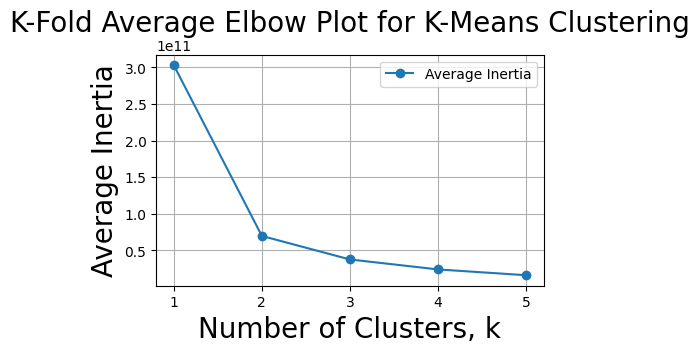

                                                      Frequency  MonetaryValue
clusterFrequency and MonetaryValue From 1st Dat...                            
1                                                   1163.754656   16473.867399
2                                                   1264.447103   32107.494979
3                                                   1327.450869   22253.423798


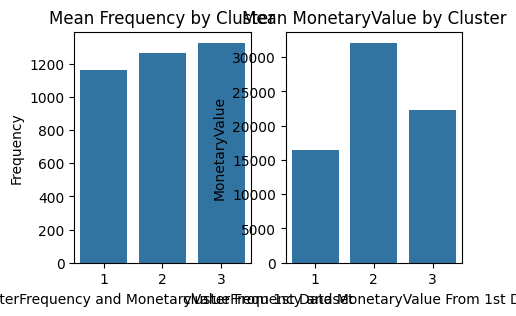

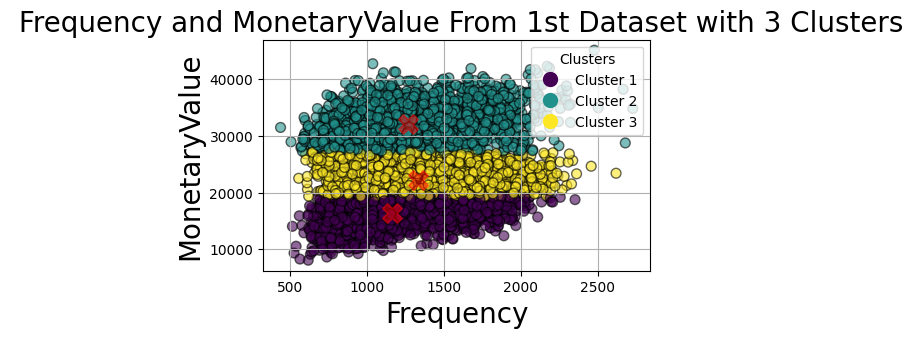

In [29]:
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize


def kmeans_kfold_elbow_with_columns_and_plot_clusters_old(df, columns, n_splits=5, max_clusters=10, plot_columns=[0, 1],txt="",optimal_clustern=3):
    X = df[columns].values  # Extracting the specified columns from the DataFrame
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    avg_inertias = np.zeros(max_clusters)
    avg_s_score = np.zeros(max_clusters)

    # Perform K-Fold cross-validation
    for train_index, _ in kf.split(X):
        X_train = X[train_index]
        inertias = []
        s_score = []
        
        for k in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            label = kmeans.fit_predict(X_train)
            
            inertias.append(kmeans.inertia_)
            
            if k > 1:
                # ss_score = silhouette_score(X_train, label)
                # s_score.append(ss_score)
                if(X_train.shape[0] < 10000):
                    sample_size = X_train.shape[0] 
                else:
                    sample_size = 10000 # Choose an appropriate size that your hardware can handle
                indices = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
                X_sampled = X_train[indices]
                labels_sampled = label[indices]
                silhouette = silhouette_score(X_sampled, labels_sampled)
                s_score.append(silhouette)


        
        avg_inertias += np.array(inertias)
        # avg_s_score += np.array(s_score)
    
    avg_inertias /= n_splits
    # s_score /= n_splits
    # print(s_score)
    print("Silhouette score: " + str(np.mean(s_score)))

    
    # Plotting the average elbow plot
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, max_clusters + 1), avg_inertias, '-o', label='Average Inertia')
    
    plt.xlabel('Number of Clusters, k', fontsize=20)
    plt.ylabel('Average Inertia', fontsize=20)
    plt.title('K-Fold Average Elbow Plot for K-Means Clustering', fontsize=20)
    plt.xticks(range(1, max_clusters + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

    optimal_cluster = optimal_clustern
    # Retrain model using the entire dataset with the optimal number of clusters
    model = KMeans(n_clusters=optimal_cluster, random_state=42)
    df['cluster'+str(txt)] = model.fit_predict(X) +1



    cluster_means = df.groupby('cluster'+str(txt))[[columns[plot_columns[0]], columns[plot_columns[1]]]].mean()
    print(cluster_means)
    # Visualizing cluster characteristics
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))

    sns.barplot(x=cluster_means.index, y=columns[plot_columns[0]], data=cluster_means, ax=axes[0])
    axes[0].set_title('Mean '+str(columns[plot_columns[0]])+' by Cluster')

    sns.barplot(x=cluster_means.index, y=columns[plot_columns[1]], data=cluster_means, ax=axes[1])
    axes[1].set_title('Mean '+str(columns[plot_columns[1]])+' by Cluster')
  
    plt.show()

    # Plotting the clusters with colormap
    cmap = plt.get_cmap('viridis')  # Define the colormap - 'viridis'
    norm = Normalize(vmin=0, vmax=len(np.unique(model.labels_))-1)  # Normalize based on the number of unique labels

    # Plotting the clusters
    plt.figure(figsize=(5, 3))
    plt.scatter(X[:, plot_columns[0]], X[:, plot_columns[1]], c=model.labels_, cmap=cmap, edgecolor='k', s=50, alpha=0.6)


    # Plotting the centroids
    centers = model.cluster_centers_
    plt.scatter(centers[:, plot_columns[0]], centers[:, plot_columns[1]], c='red', s=200, alpha=0.5, marker='X')
    plt.xlabel(columns[plot_columns[0]], fontsize=20)
    plt.ylabel(columns[plot_columns[1]], fontsize=20)
    plt.title(' '+str(txt)+f' with {optimal_cluster} Clusters', fontsize=20)
    
    # Generate a list of markers, one for each cluster, with the correct color from the colormap
    legend_handles = [
        Line2D([0], [0], marker='o', color=cmap(norm(i)), linestyle='', markersize=10, label=f'Cluster {i+1}')
        for i in range(len(np.unique(model.labels_)))
    ]

    # Adding the legend to the plot
    plt.legend(handles=legend_handles, title="Clusters")

    plt.grid(True)
    plt.show()

# kmeans_kfold_elbow_with_columns_and_plot_clusters_old(rfm_first_dataset, ['Frequency','MonetaryValue'], n_splits=5, max_clusters=5, plot_columns=[0, 1],txt="Frequency and MonetaryValue From 1st Dataset",optimal_clustern=3)


In [19]:
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from sklearn.preprocessing import StandardScaler

def kmeans_elbow_with_columns_and_plot_clusters(df, columns, n_splits=5, max_clusters=10, plot_columns=[0, 1],txt="",optimal_clustern=3):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[columns])

    k = optimal_clustern
    model = KMeans(n_clusters=k, random_state=42)
    # df['cluster' + str(txt)] = model.fit_predict(X_scaled)
    # df['cluster'+str(txt)] 
    df.loc[:, 'cluster' + str(txt)] = model.fit_predict(X_scaled) + 1

    # Sample a subset of your scaled data and labels
    if(X_scaled.shape[0] < 10000):
        sample_size = X_scaled.shape[0] 
    else:
        sample_size = 10000 # Choose an appropriate size that your hardware can handle
    indices = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)
    X_sampled = X_scaled[indices]
    labels_sampled = df['cluster'+str(txt)].iloc[indices]

    silhouette = silhouette_score(X_sampled, labels_sampled)
    print("Silhouette score: " + str(silhouette))
    # silhouette = silhouette_score(X_scaled, df['cluster'+str(txt)] )
    # print("Silhouette score: "+str(silhouette))


    cluster_means = df.groupby('cluster'+str(txt))[[columns[0], columns[1]]].mean()
    print(cluster_means)
    # Visualizing cluster characteristics
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))
    sns.barplot(x=cluster_means.index, y=cluster_means[columns[0]], data=cluster_means, ax=axes[0])
    axes[0].set_title('Mean '+str(columns[0])+' by Cluster')

    sns.barplot(x=cluster_means.index, y=cluster_means[columns[1]], data=cluster_means, ax=axes[1])
    axes[1].set_title('Mean '+str(columns[1])+' by Cluster')
  
    plt.show()

    # Plotting the clusters with colormap
    cmap = plt.get_cmap('viridis')  # Define the colormap - 'viridis'
    norm = Normalize(vmin=0, vmax=len(np.unique(model.labels_))-1)  # Normalize based on the number of unique labels

    # Plotting the clusters
    plt.figure(figsize=(5, 3))
    plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_, cmap=cmap, edgecolor='k', s=50, alpha=0.6)

    # Plotting the centroids
    centers = model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='X')
    plt.xlabel(columns[0], fontsize=20)
    plt.ylabel(columns[1], fontsize=20)
    plt.title(' '+str(txt)+f' With {k} Clusters', fontsize=15)
 
    # Generate a list of markers, one for each cluster, with the correct color from the colormap
    legend_handles = [
        Line2D([0], [0], marker='o', color=cmap(norm(i)), linestyle='', markersize=10, label=f'Cluster {i+1}')
        for i in range(len(np.unique(model.labels_)))
    ]

    # Adding the legend to the plot
    plt.legend(handles=legend_handles, title="Clusters")

    plt.grid(True)
    plt.show()


    return model,df



# # Balance vs amount cluster 2 and 3
# selected_columns =  ['Balance', 'Amount'] 
# kmeans_elbow_with_columns_and_plot_clusters(df_simulated_transaction_2024_subset, selected_columns, max_clusters=10, plot_columns=[0, 1],txt="Balance and Amount 2",optimal_clustern=2)


### K-mean clustering: Data model with K-fold validation with WillingnessToSpend

### run all analysis

#### See the category distribution in each features

In [20]:


def plot_stacked_bar(cluster,feature_name,feature_data,ax_nunmber):
    feature_data.set_index('Category', inplace=True)
    df_t = feature_data.T

    # Plotting the stacked bar chart
    ax = df_t.plot(kind='bar', stacked=True, figsize=(4, 6))
    ax.set_title('Percentage Distribution Across Categories')
    ax.set_ylabel('Percentage')
    ax.set_xlabel("Cluster: "+str(cluster)+" Feature: "+str(feature_name))
    plt.xticks(ticks=[0], labels=['Distribution'])
    plt.legend(title='Category')
    
    label_font_size = 10
    # Adding percentage labels
    for bar in ax.patches:  # iterate through each bar segment
        # Get the placement info of each bar
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x()
        y = bar.get_y()

        label_text = f'{height:.2f}%'  # Format the number
        label_x = x + width / 2  # x position is center of the bar
        label_y = y + height / 2  # y position is center of the bar height

        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize= label_font_size, color='black')
    plt.show()


def show_clusters_in_ranking(all_feature_to_print,df_tmppp,clustername,clustern,limitation_topnumber,datasets_number):
    clustername = "cluster"+str(clustername)
    # Customer percentage
    Customer_Percentage = df_tmppp[clustername].value_counts(normalize=True)  * 100
    print("Customer Distribution Percentage:")
    print(Customer_Percentage)
    for i in range(len(Customer_Percentage)):
        print("Cluster "+str(i+1)+": "+str(round(Customer_Percentage[i+1],2))+"%")
    #Top limitation_topnumber of Top number
    feature_stacks = {j: {} for j in range(1,clustern+1)}
    for j in range(1,clustern+1):
        for feature in all_feature_to_print:
            cluster1 = df_tmppp[df_tmppp[clustername] == j]
            # Step 2: Count the occurrences of each category in 'WillingnessToSpend'
            top_categories = cluster1[feature].value_counts().head(10).index
            # # Step 3: Filter the DataFrame again to keep only the top 10 categories
            top_categories_df = cluster1[cluster1[feature].isin(top_categories)]
            Percentage_tmp = top_categories_df[feature].value_counts(normalize=True)  * 100
            concat_string = ""
            ending = ","
            if(len(top_categories) < limitation_topnumber):
                limitation_topnumber = len(top_categories)
            for s in range(limitation_topnumber):
                if(s == limitation_topnumber-1):
                    ending = ""
                concat_string = concat_string +str(top_categories[s])+":"+str(round(Percentage_tmp[top_categories[s]],2))+"%" + ending
            head_tmp = Percentage_tmp.head(limitation_topnumber)
            df_tmp = head_tmp.reset_index()
            df_tmp.columns = ['Category', 'Percentage']  # Renaming columns to match your requirement
            # print(j,feature)
            feature_stacks[j][feature] = df_tmp
    for cluster, features in feature_stacks.items():

        ncols_set = len(feature_stacks)
        ax_count = 0
        fig, axes = plt.subplots(nrows=1, ncols=ncols_set, figsize=(7.5, 4))
        for k in features.keys():
            label_font_size = 10
            features[k].set_index('Category', inplace=True)
            df_t = features[k].T
            print(features[k]) ### important
            df_t.plot(kind='bar', stacked=True, ax=axes[ax_count])
            axes[ax_count].set_ylabel('Percentage')
            axes[ax_count].set_xlabel(k)
            axes[ax_count].tick_params(axis='x', labelbottom=False) 
            
            # Adding percentage labels
            for bar in axes[ax_count].patches:  # iterate through each bar segment
                # Get the placement info of each bar
                height = bar.get_height()
                width = bar.get_width()
                x = bar.get_x()
                y = bar.get_y()

                label_text = f'{height:.2f}%'  # Format the number
                label_x = x + width / 2  # x position is center of the bar
                label_y = y + height / 2  # y position is center of the bar height

                axes[ax_count].text(label_x, label_y, label_text, ha='center', va='center', fontsize= label_font_size, color='black')
            ax_count += 1
        # Adjust subplot padding
        fig.subplots_adjust(wspace=0.1)  # Adjust this value as needed to change spacing
        # Adjust legend for the entire figure
        plt.legend(loc='lower right',title='Category')
        fig.suptitle('Cluster: '+str(cluster), fontsize=12)
        fig.tight_layout()  # Adjust layout to prevent overlap
        plt.show()


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# and 'Balance' and 'Amount' are the columns for which you want to plot histograms.
def plothistrogram(dfff,feature1,feature2,hue):
    dfff.loc[:,'log_'+str(feature1)] = np.log1p(dfff[feature1])
    dfff.loc[:,'log_'+str(feature2)] = np.log1p(dfff[feature2])
    
    # Set up the plotting area
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)  # Sharey to have the same y-axis scale for comparison

    # Plot histogram for "Balance" with clusters differentiated by hue
    sns.histplot(data=dfff, x='log_'+str(feature1), hue=hue, ax=axes[0], kde=True, bins=30, palette='viridis', element='step', common_norm=False)
    axes[0].set_title(str(feature1)+' Distribution by Cluster')

    # Plot histogram for "Amount" with clusters differentiated by hue
    sns.histplot(data=dfff, x='log_'+str(feature2), hue=hue, ax=axes[1], kde=True, bins=30, palette='viridis', element='step', common_norm=False)
    axes[1].set_title(str(feature2)+' Distribution by Cluster')

    plt.tight_layout()
    plt.show()

cls = "cluster"


#### all details in each cluster

In [22]:
def function_run_all(datasett,strtext,selected_columns,clusterrn,f1,f2,dataset_number):
    print(strtext)
    if(dataset_number == 'rfm with first dataset kfold'): #rfm with first dataset
         kmeans_kfold_elbow_with_columns_and_plot_clusters_old(datasett, selected_columns, max_clusters=10, plot_columns=[0, 1],txt=strtext,optimal_clustern=clusterrn) ## kfold
         plothistrogram(datasett,f1,f2,"cluster"+strtext)
         all_features = ['WillingnessToSpend','TransferredLocationAccount','CategoryTransferredLocationAccount']
         selected_columns = datasett[['cluster'+str(strtext)]]
         selected_columns = selected_columns.reset_index()
         datasett = pd.merge(dataset1_merged_df, selected_columns, on='AccountNumber', how='left')
    elif(dataset_number == 'rfm with first dataset without kfold'): #rfm with first dataset
         kmeans_elbow_with_columns_and_plot_clusters(datasett, selected_columns, max_clusters=10, plot_columns=[0, 1],txt=strtext,optimal_clustern=clusterrn) ## NOT kfold
         plothistrogram(datasett,f1,f2,"cluster"+strtext)
         all_features = ['WillingnessToSpend','TransferredLocationAccount','CategoryTransferredLocationAccount']
         selected_columns = datasett[['cluster'+str(strtext)]]
         selected_columns = selected_columns.reset_index()
         datasett = pd.merge(dataset1_merged_df, selected_columns, on='AccountNumber', how='left')
    elif(dataset_number == 'rfm with second dataset'): #rfm with first dataset
        #  print(datasett.columns)
         kmeans_kfold_elbow_with_columns_and_plot_clusters_old(datasett, selected_columns, max_clusters=10, plot_columns=[0, 1],txt=strtext,optimal_clustern=clusterrn) ## kfold
         plothistrogram(datasett,f1,f2,"cluster"+strtext)
         all_features = ['WillingnessToSpend','Third Party Name Account','Third Party Name cagtegory']
         selected_columns = datasett[['cluster'+str(strtext)]]
         selected_columns = selected_columns.reset_index()
        #  selected_columns.rename(columns={'Account No': 'AccountNumber'})
         print(selected_columns)
         datasett = pd.merge(outgoing_payments, selected_columns, on='Account No', how='left')
         print(datasett.columns)
    elif(dataset_number == 'second dataset'):
        kmeans_kfold_elbow_with_columns_and_plot_clusters_old(datasett, selected_columns, max_clusters=10, plot_columns=[0, 1],txt=strtext,optimal_clustern=clusterrn) ## kfold
        plothistrogram(datasett,f1,f2,"cluster"+strtext)
        all_features = ['WillingnessToSpend','Third Party Name Account','Third Party Name cagtegory']
    elif(dataset_number == "first dataset"):
        kmeans_kfold_elbow_with_columns_and_plot_clusters_old(datasett, selected_columns, max_clusters=10, plot_columns=[0, 1],txt=strtext,optimal_clustern=clusterrn) ## kfold
        plothistrogram(datasett,f1,f2,"cluster"+strtext)
        all_features = ['WillingnessToSpend','TransferredLocationAccount','CategoryTransferredLocationAccount']
    
    show_clusters_in_ranking(all_features,datasett, strtext,clusterrn,5,dataset_number)


#### Balance VS amount Cluster 3

Balance And Amount From 2nd Dataset(Outgoing)
Silhouette score: 0.5617207107087334


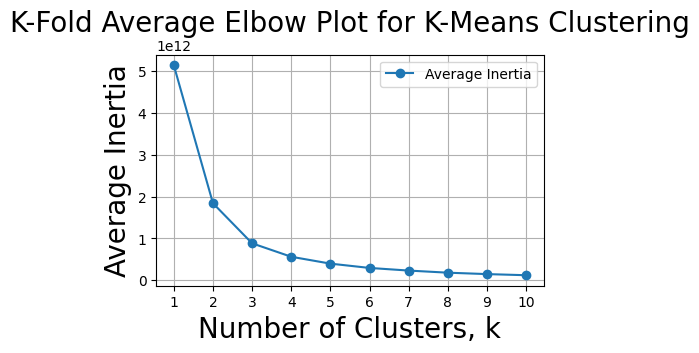

                                                         Balance     Amount
clusterBalance And Amount From 2nd Dataset(Outg...                         
1                                                     984.209606 -92.795462
2                                                    8029.722645 -61.135552
3                                                   21002.184644 -53.805311


/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/1861835148.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'+str(txt)] = model.fit_predict(X) +1


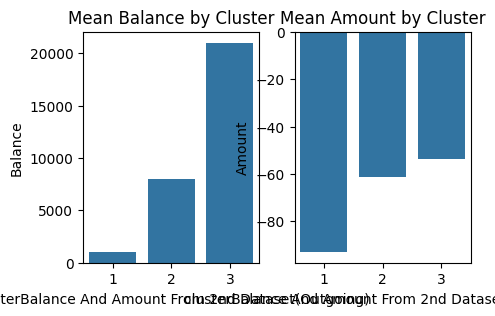

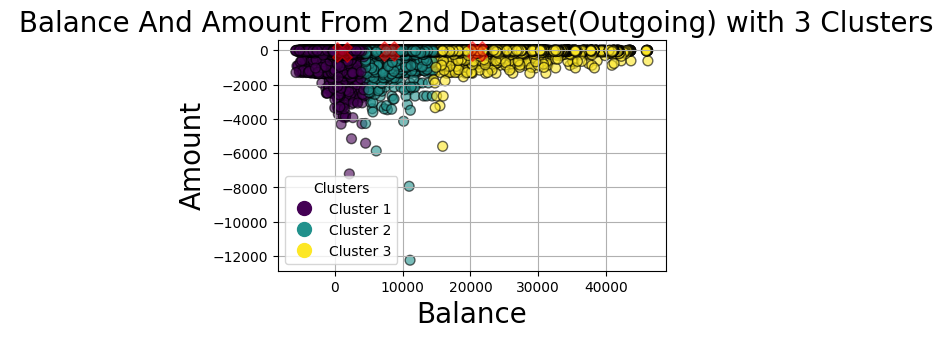

/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/1820216638.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfff.loc[:,'log_'+str(feature1)] = np.log1p(dfff[feature1])
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encounter

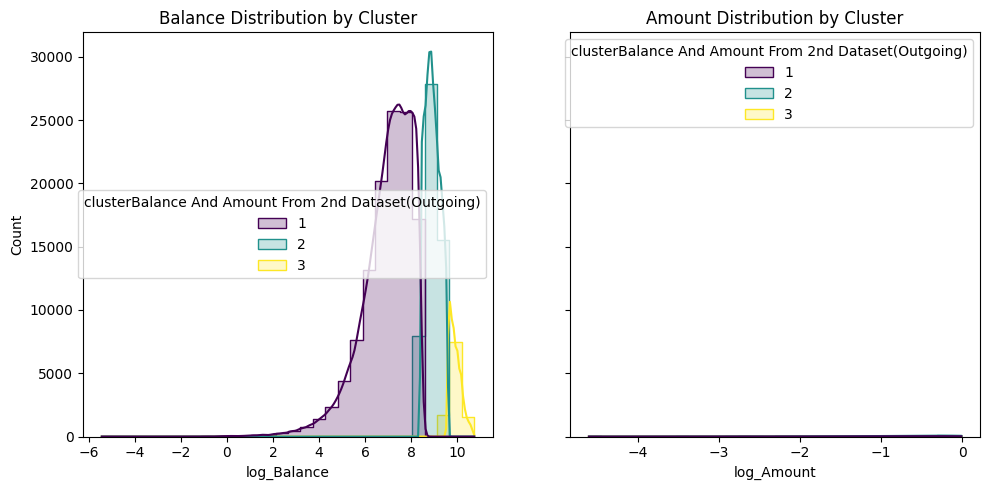

Customer Distribution Percentage:
clusterBalance And Amount From 2nd Dataset(Outgoing)
1    71.680576
2    23.429539
3     4.889885
Name: proportion, dtype: float64
Cluster 1: 71.68%
Cluster 2: 23.43%
Cluster 3: 4.89%
            Percentage
Category              
Numeric      35.198808
healthcare   16.631025
art           9.397231
clothing      9.355887
finance       8.260268
               Percentage
Category                 
Tesco           31.685024
Sports Direct   15.079675
Topshop          8.440065
PureGym          7.930741
Fat Face         7.589275
              Percentage
Category                
grocery        21.702803
clothing       17.928521
gaming         12.066077
sport          10.389530
subscription    9.898600


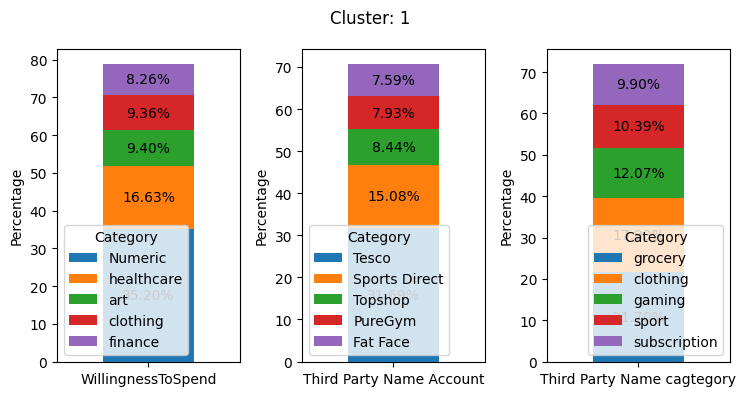

            Percentage
Category              
finance      29.730509
healthcare   23.272188
clothing     12.187841
education     9.484693
pet           6.664196
               Percentage
Category                 
Tesco           20.545447
Amazon          10.718858
JustEat         10.330915
Deliveroo       10.230050
Sports Direct   10.113667
              Percentage
Category                
clothing       23.928967
grocery        19.506430
subscription   11.811175
delivery       11.285240
art             8.536326


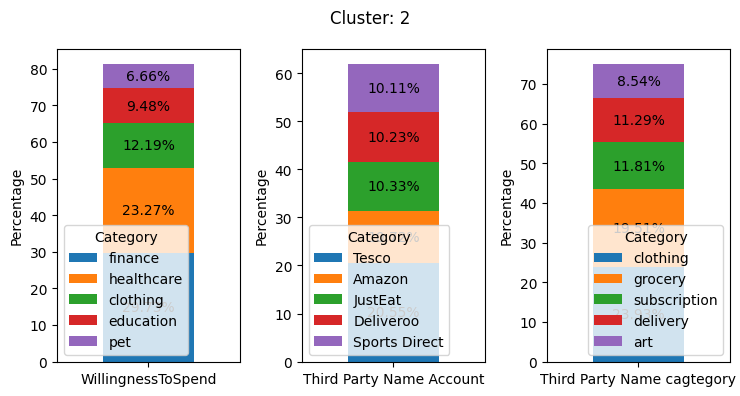

            Percentage
Category              
finance      42.311642
healthcare   28.998226
education    17.888152
clothing      5.116236
department    1.829895
           Percentage
Category             
JustEat     16.874893
Tesco       15.385932
Deliveroo   14.872497
Amazon      10.576759
Topshop      8.403218
              Percentage
Category                
clothing       23.686900
delivery       18.955651
grocery        17.392193
subscription   11.802575
art             6.499080


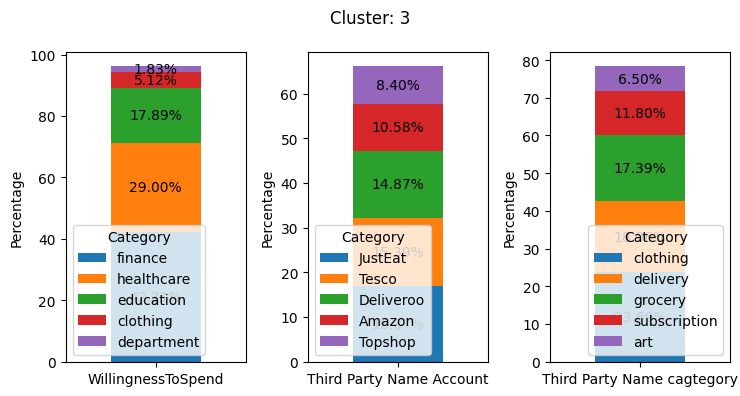

In [30]:
function_run_all(outgoing_payments,"Balance And Amount From 2nd Dataset(Outgoing)",['Balance','Amount'],3,'Balance','Amount','second dataset')

#### Frequency and MonetaryValue 3

Frequency MonetaryValue From 2nd Dataset(Outgoing)
Silhouette score: 0.6649280763350224


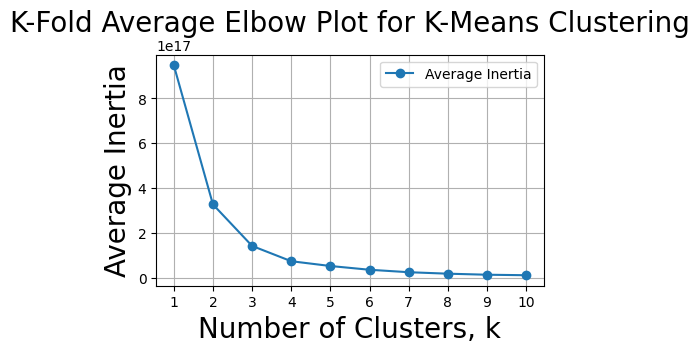

                                                     Frequency  MonetaryValue
clusterFrequency MonetaryValue From 2nd Dataset...                           
1                                                   238.749486   4.166152e+05
2                                                   463.610392   3.790778e+06
3                                                   546.823791   1.045859e+07


/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/1861835148.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'+str(txt)] = model.fit_predict(X) +1


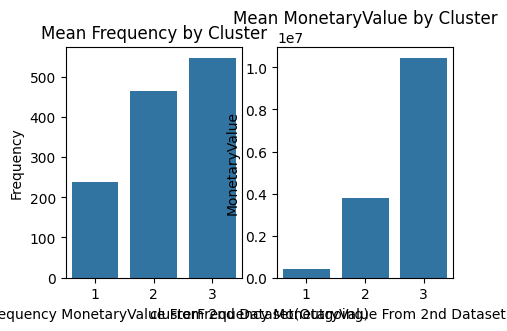

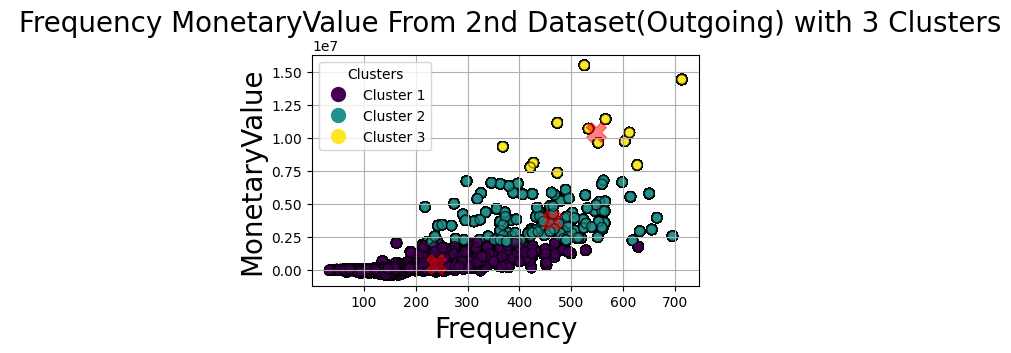

/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/1820216638.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfff.loc[:,'log_'+str(feature1)] = np.log1p(dfff[feature1])
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/1820216638.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

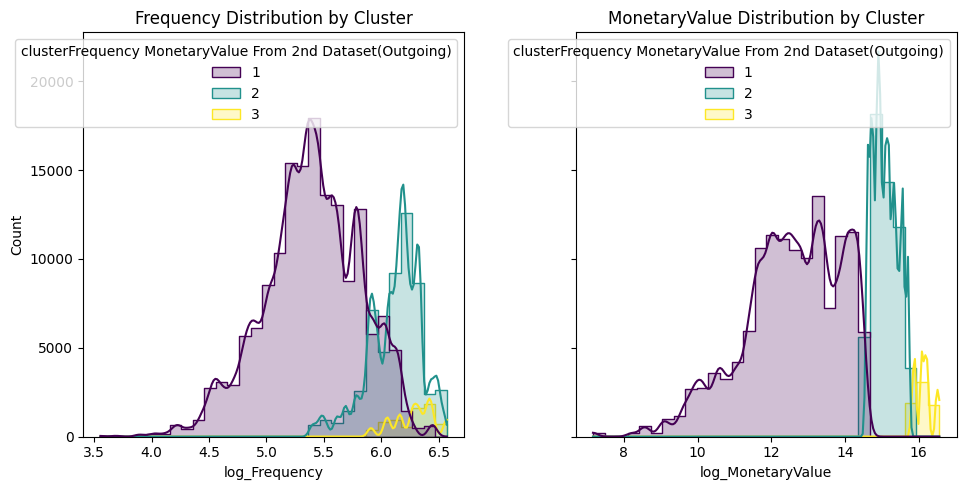

Customer Distribution Percentage:
clusterFrequency MonetaryValue From 2nd Dataset(Outgoing)
1    72.390022
2    24.532057
3     3.077920
Name: proportion, dtype: float64
Cluster 1: 72.39%
Cluster 2: 24.53%
Cluster 3: 3.08%
            Percentage
Category              
Numeric      34.532028
healthcare   16.947007
art          10.248557
clothing      9.598517
finance       7.491371
               Percentage
Category                 
Tesco           30.984748
Sports Direct   15.010278
Topshop          8.608452
PureGym          8.090582
Fat Face         7.671516
              Percentage
Category                
grocery        21.515645
clothing       18.347248
gaming         11.974479
sport          10.388244
subscription   10.283717


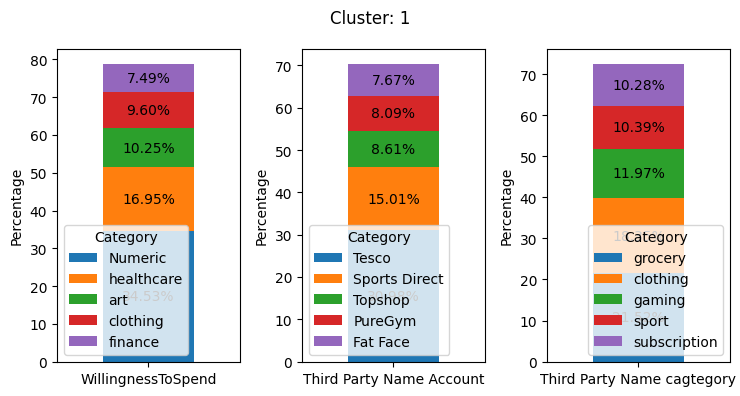

            Percentage
Category              
finance      34.127478
healthcare   22.695297
clothing     10.909444
education     8.789351
pet           5.961912
               Percentage
Category                 
Tesco           20.927708
JustEat         11.636153
Deliveroo       11.306896
Amazon          10.036906
Sports Direct    9.609957
              Percentage
Category                
clothing       22.726997
grocery        19.782552
delivery       12.814502
subscription   10.852212
art             8.758564


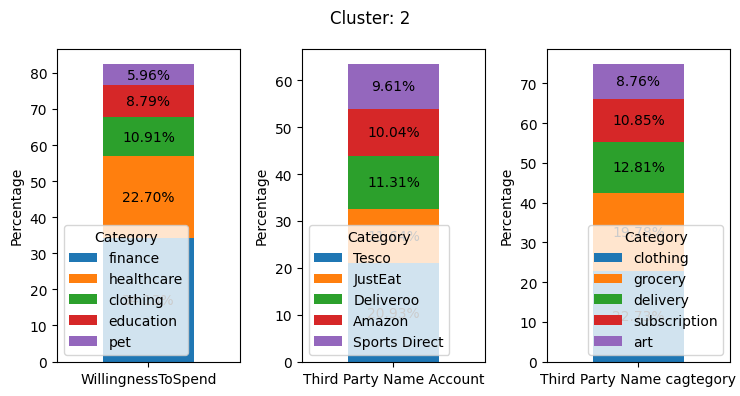

            Percentage
Category              
finance      35.716405
healthcare   31.192524
education    27.024622
clothing      6.066449
           Percentage
Category             
Tesco       18.198675
JustEat     14.701987
Deliveroo   12.370861
Amazon       9.377483
              Percentage
Category                
clothing       24.469821
grocery        18.205546
delivery       16.672104
subscription   10.734095


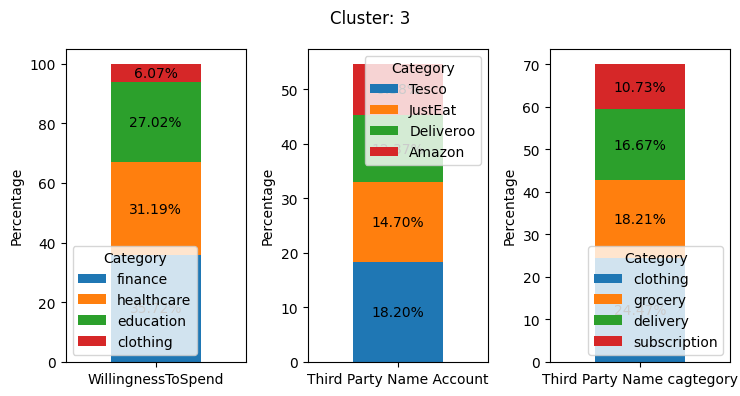

In [31]:
function_run_all(outgoing_payments,"Frequency MonetaryValue From 2nd Dataset(Outgoing)",['Frequency','MonetaryValue'],3,'Frequency','MonetaryValue','second dataset') 


Frequency and MonetaryValue From 1st Dataset
Silhouette score: 0.5190127793871802


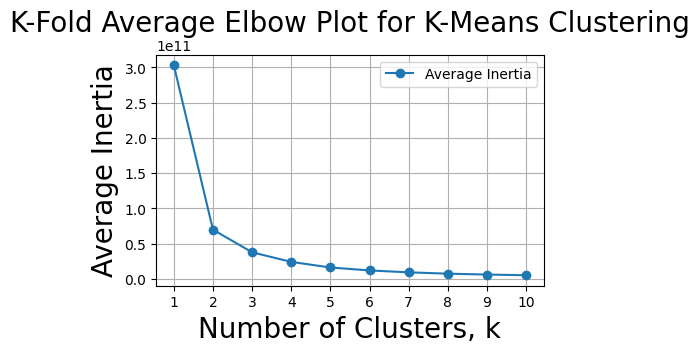

                                                      Frequency  MonetaryValue
clusterFrequency and MonetaryValue From 1st Dat...                            
1                                                   1163.754656   16473.867399
2                                                   1264.447103   32107.494979
3                                                   1327.450869   22253.423798


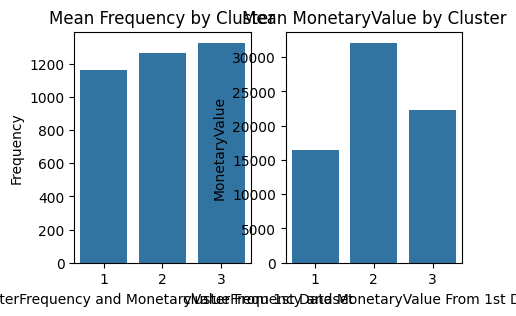

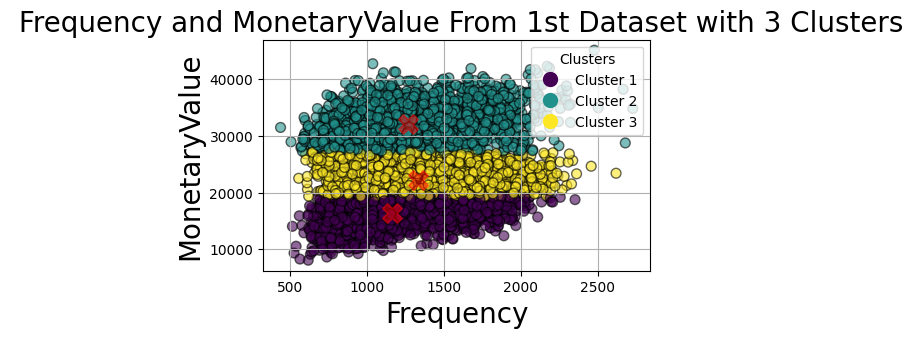

/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = gr

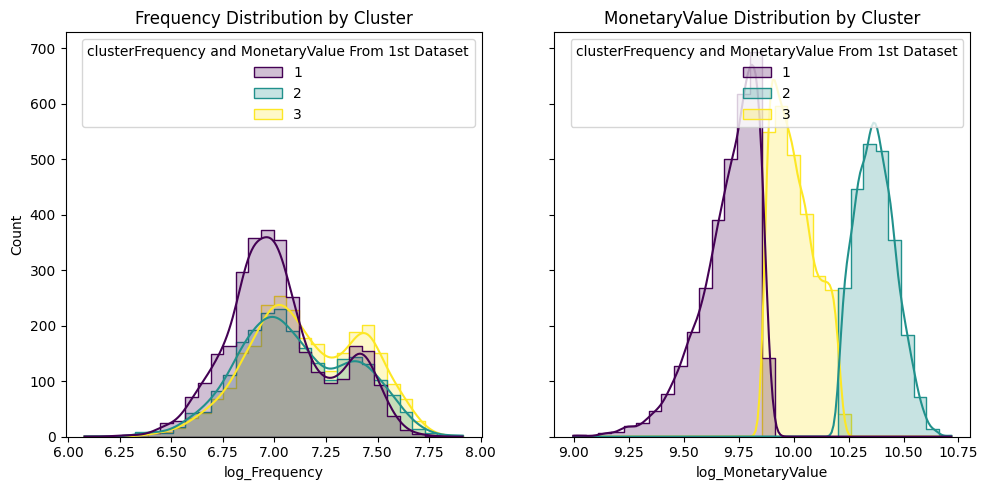

Customer Distribution Percentage:
clusterFrequency and MonetaryValue From 1st Dataset
1    35.709815
3    34.611136
2    29.679049
Name: proportion, dtype: float64
Cluster 1: 35.71%
Cluster 2: 29.68%
Cluster 3: 34.61%
            Percentage
Category              
CLOTHING     49.292221
GROCERY      23.355331
ELECTRONIC   15.483003
HEALTH        5.265912
KIDS          3.866484
                            Percentage
Category                              
PUB                          18.282365
BAR                          16.970956
LOCAL_WATERING_HOLE          14.260086
TOTALLY_A_REAL_COFFEE_SHOP    9.644444
A_CAFE                        9.600303
            Percentage
Category              
BAR          29.642347
Numeric      26.636600
COFFEE       24.797980
LUNCH         4.853591
RESTAURANT    3.339678


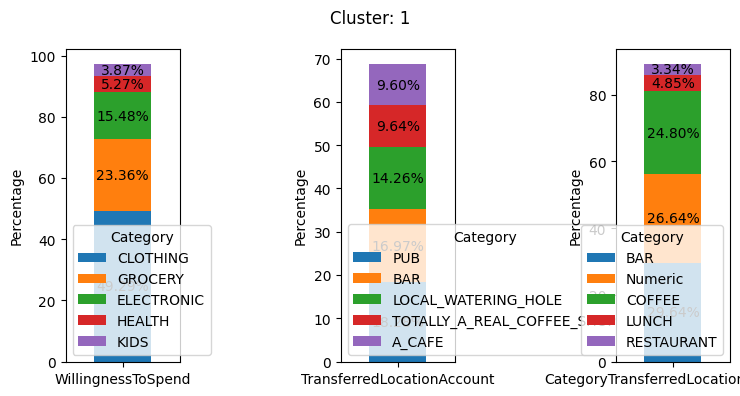

            Percentage
Category              
CLOTHING     53.085564
ELECTRONIC   16.810413
GROCERY      15.091173
Numeric       9.635570
HEALTH        2.970239
                            Percentage
Category                              
PUB                          16.985034
BAR                          15.661255
LOCAL_WATERING_HOLE          13.271338
COFFEE_SHOP                   9.866478
TOTALLY_A_REAL_COFFEE_SHOP    9.816680
             Percentage
Category               
BAR           27.346396
COFFEE        26.597473
Numeric       25.362885
LUNCH          6.065166
SUPERMARKET    3.588238


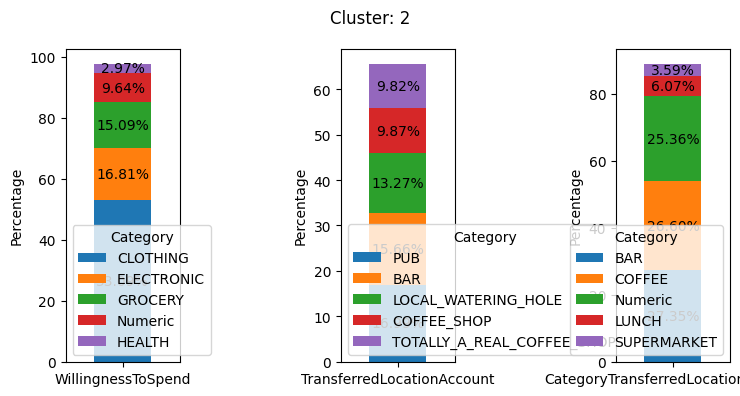

            Percentage
Category              
CLOTHING     59.691240
ELECTRONIC   16.994564
GROCERY      13.661036
HEALTH        4.132005
KIDS          2.720848
                     Percentage
Category                       
PUB                   16.250842
BAR                   14.930972
LOCAL_WATERING_HOLE   12.551261
COFFEE_SHOP            9.989512
A_CAFE                 9.982584
             Percentage
Category               
COFFEE        27.997995
BAR           26.615705
Numeric       25.185943
LUNCH          6.129667
SUPERMARKET    3.522822


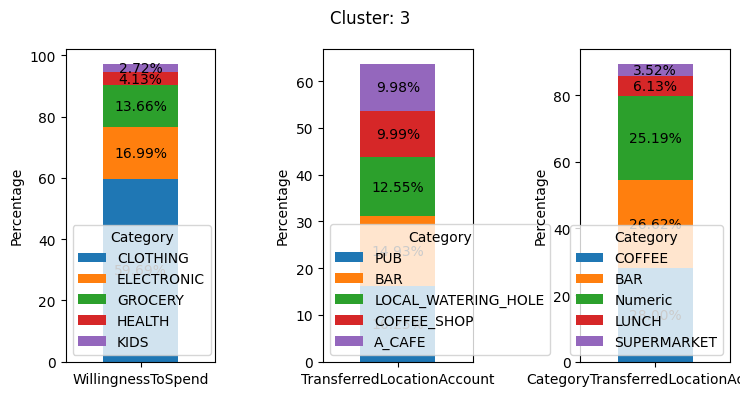

In [32]:
function_run_all(rfm_first_dataset,"Frequency and MonetaryValue From 1st Dataset",['Frequency','MonetaryValue'],3,'Frequency','MonetaryValue','rfm with first dataset kfold') 


In [ ]:
function_run_all(rfm_first_dataset,"Frequency and MonetaryValue From 1st Dataset",['Frequency','MonetaryValue'],3,'Frequency','MonetaryValue','rfm with first dataset without kfold') 



#### Frequency VS Amount Cluster 3


Frequency and Amount 3 outcome
Silhouette score: 0.47952530647843655


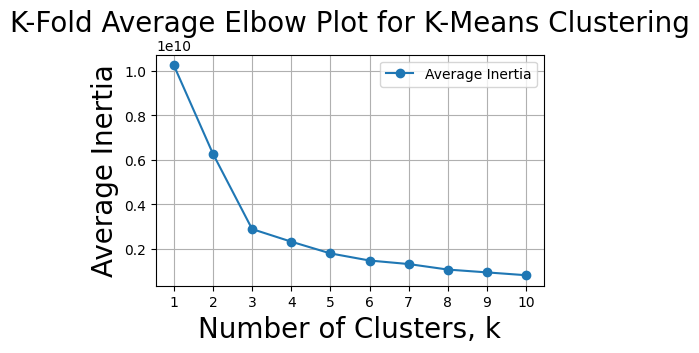

                                        Frequency      Amount
clusterFrequency and Amount 3 outcome                        
1                                      212.236727  -57.992660
2                                      243.270702 -931.536119
3                                      469.899945  -40.220141


/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/1861835148.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'+str(txt)] = model.fit_predict(X) +1


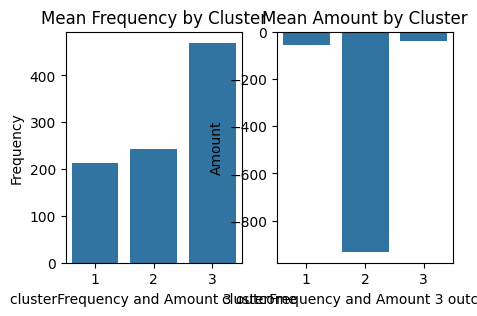

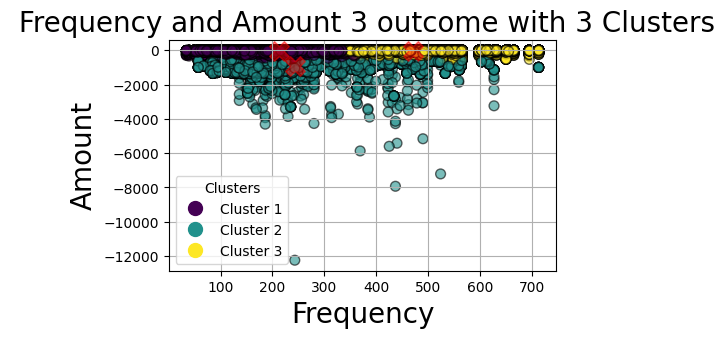

/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pand

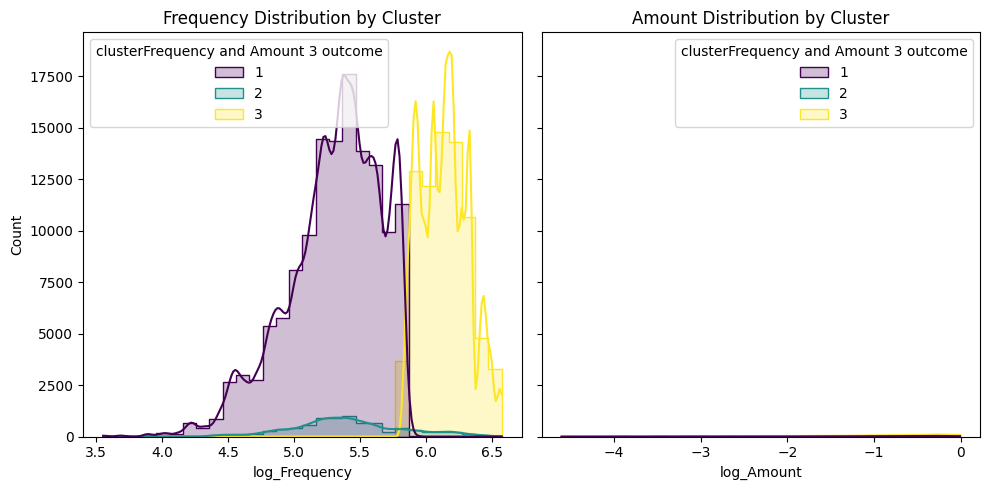

Customer Distribution Percentage:
clusterFrequency and Amount 3 outcome
1    61.430580
3    34.941838
2     3.627582
Name: proportion, dtype: float64
Cluster 1: 61.43%
Cluster 2: 3.63%
Cluster 3: 34.94%
            Percentage
Category              
Numeric      35.954673
healthcare   17.258077
finance       9.057932
clothing      8.760910
art           7.662676
               Percentage
Category                 
Tesco           31.823429
Sports Direct   15.000559
Topshop          8.423849
PureGym          8.320816
Netflix          7.854066
              Percentage
Category                
grocery        22.519369
clothing       18.149019
gaming         12.973056
sport          10.889257
subscription   10.536946


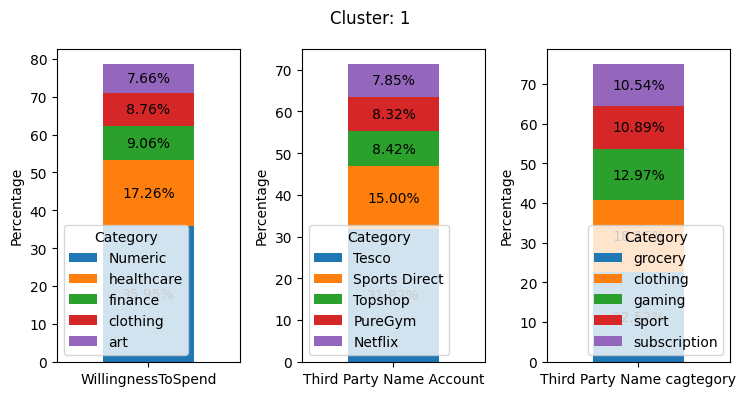

            Percentage
Category              
healthcare   25.072927
finance      17.266287
clothing     11.223781
art           9.931935
education     9.681900
             Percentage
Category               
Halifax       50.009122
LBG           47.509579
248658670.0    0.346652
280098744.0    0.328407
414454079.0    0.328407
          Percentage
Category            
finance    67.266549
Numeric    32.733451


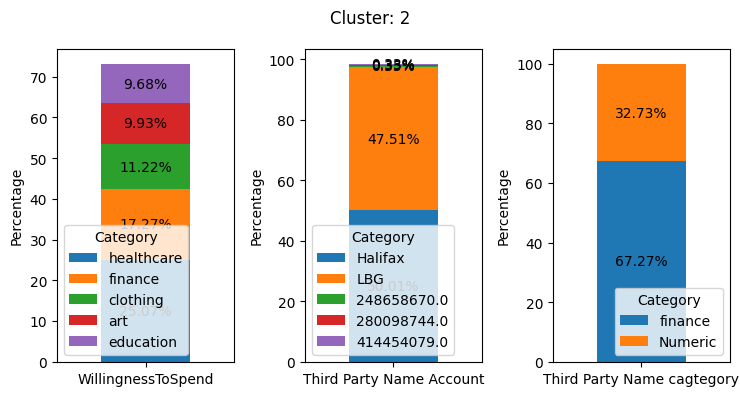

            Percentage
Category              
finance      25.745935
healthcare   21.222831
          Percentage
Category            
Tesco      20.022691
JustEat    11.150848
          Percentage
Category            
clothing   22.615830
grocery    18.656841


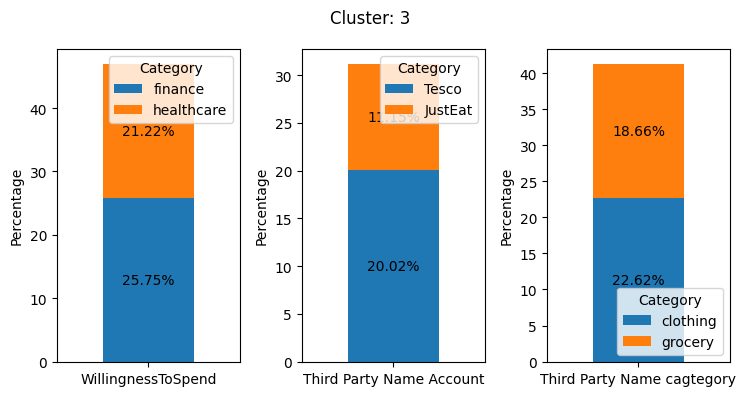

In [33]:
function_run_all(outgoing_payments,"Frequency and Amount 3 outcome",['Frequency','Amount'],3,'Frequency','Amount','second dataset')

Frequency and MoneyTransferAmount 3 outcome
Silhouette score: 0.5186052755939539


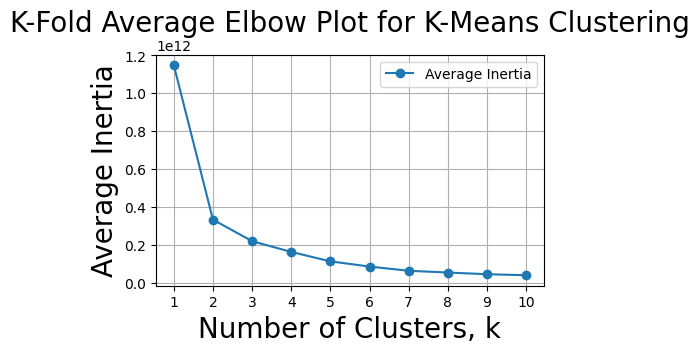

                                                      Frequency  \
clusterFrequency and MoneyTransferAmount 3 outcome                
1                                                   1349.563225   
2                                                   1804.944321   
3                                                    995.627235   

                                                    MoneyTransferAmount  
clusterFrequency and MoneyTransferAmount 3 outcome                       
1                                                             17.508965  
2                                                             13.443985  
3                                                             22.684575  


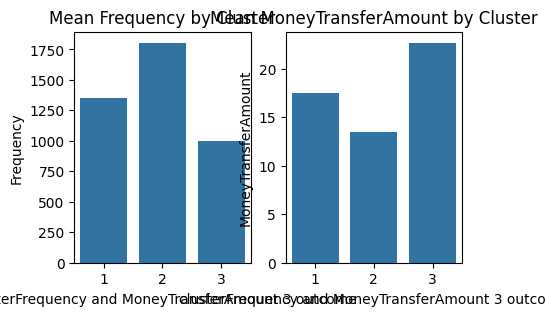

/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


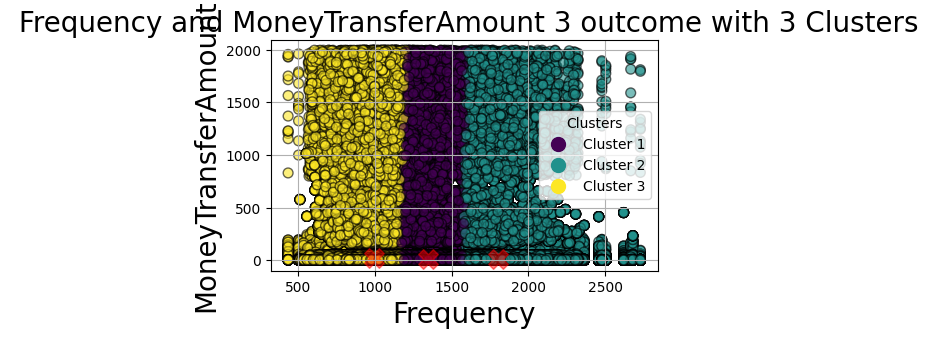

/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = gr

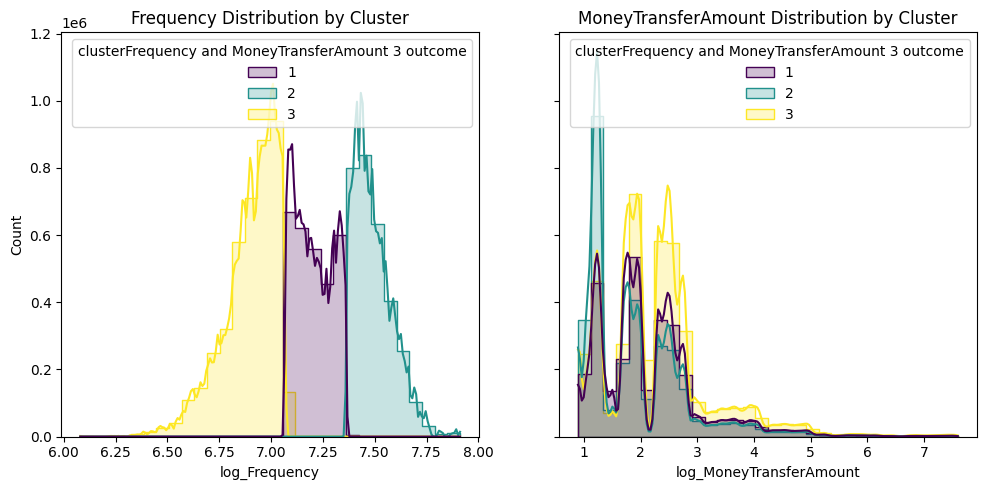

Customer Distribution Percentage:
clusterFrequency and MoneyTransferAmount 3 outcome
3    40.944475
2    30.371767
1    28.683757
Name: proportion, dtype: float64
Cluster 1: 28.68%
Cluster 2: 30.37%
Cluster 3: 40.94%
            Percentage
Category              
CLOTHING     55.617740
ELECTRONIC   16.691739
GROCERY      16.214393
HEALTH        4.265421
Numeric       2.957866
                            Percentage
Category                              
PUB                          17.550250
BAR                          16.221062
LOCAL_WATERING_HOLE          13.630408
COFFEE_SHOP                   9.775085
TOTALLY_A_REAL_COFFEE_SHOP    9.748164
            Percentage
Category              
BAR          26.988852
Numeric      26.294647
COFFEE       22.194739
LUNCH         9.596484
RESTAURANT    4.024204


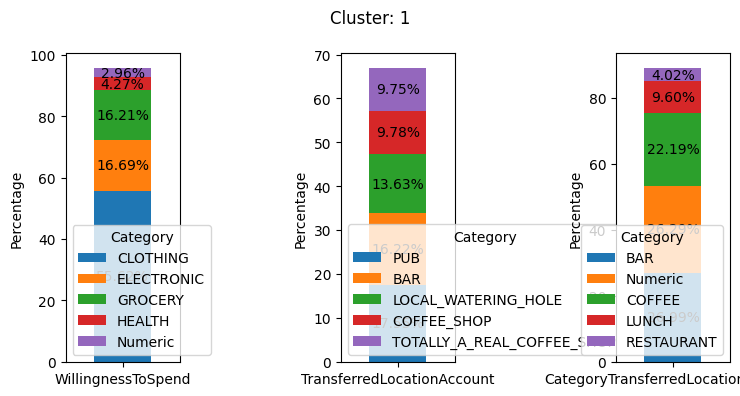

            Percentage
Category              
CLOTHING     54.818737
ELECTRONIC   17.281956
GROCERY      16.217449
HEALTH        4.693526
KIDS          3.092139
                            Percentage
Category                              
COFFEE_SHOP                  10.569214
TOTALLY_A_REAL_COFFEE_SHOP   10.558367
A_CAFE                       10.536190
A_LOCAL_COFFEE_SHOP          10.501082
PRETENTIOUS_COFFEE_SHOP      10.156896
            Percentage
Category              
COFFEE       45.097827
BAR          20.536937
Numeric      19.016228
LUNCH         4.857295
RESTAURANT    2.496371


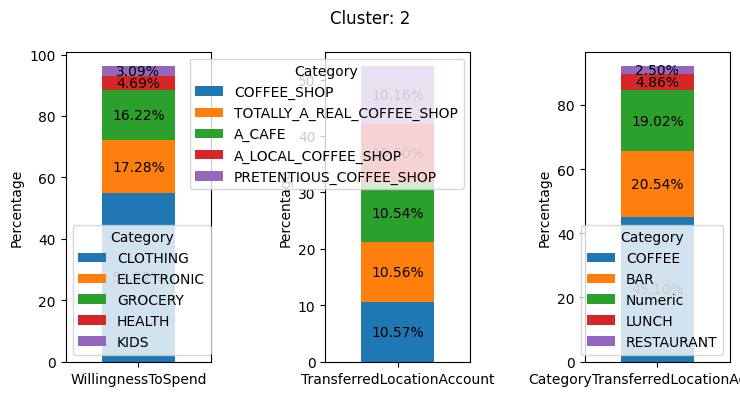

            Percentage
Category              
CLOTHING     52.320284
GROCERY      19.467561
ELECTRONIC   15.547164
Numeric       5.097571
HEALTH        3.769314
                            Percentage
Category                              
PUB                          21.815649
BAR                          20.019258
LOCAL_WATERING_HOLE          16.886582
TOTALLY_A_REAL_COFFEE_SHOP    7.905681
A_CAFE                        7.896655
             Percentage
Category               
BAR           34.128244
Numeric       30.456053
COFFEE        15.377096
SUPERMARKET    4.166014
RESTAURANT     3.546635


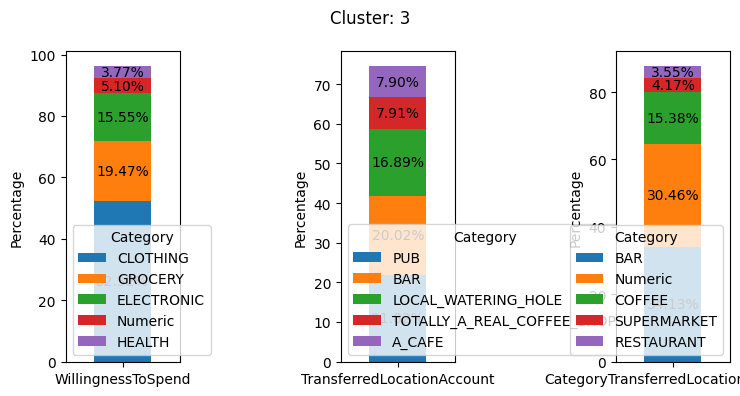

In [34]:
function_run_all(dataset1_merged_df,"Frequency and MoneyTransferAmount 3 outcome",['Frequency','MoneyTransferAmount'],3,'Frequency','MoneyTransferAmount','first dataset')

#### Frequency VS Balance Cluster 3

Frequency and Balance 3 outcome
Silhouette score: 0.5687945504558557


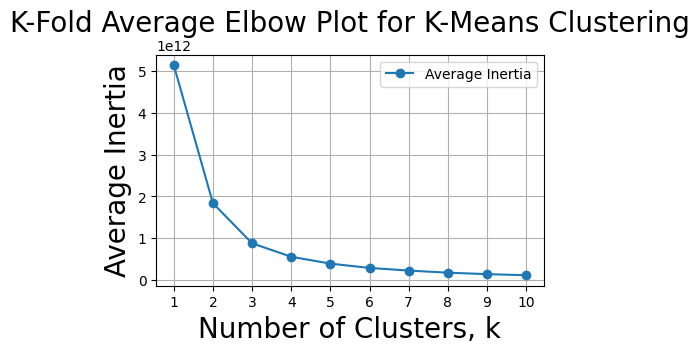

                                         Frequency       Balance
clusterFrequency and Balance 3 outcome                          
1                                       250.069971    975.785629
2                                       451.573879  20923.468038
3                                       434.217915   7987.532791


/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/1861835148.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'+str(txt)] = model.fit_predict(X) +1


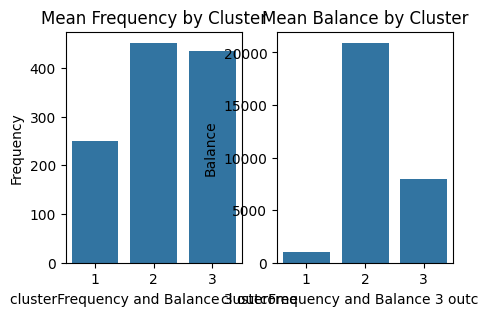

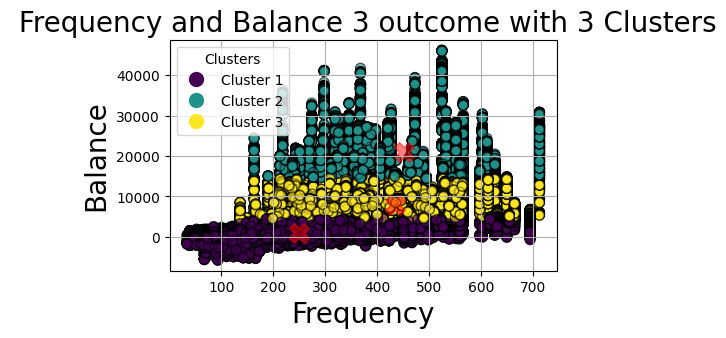

/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: Futu

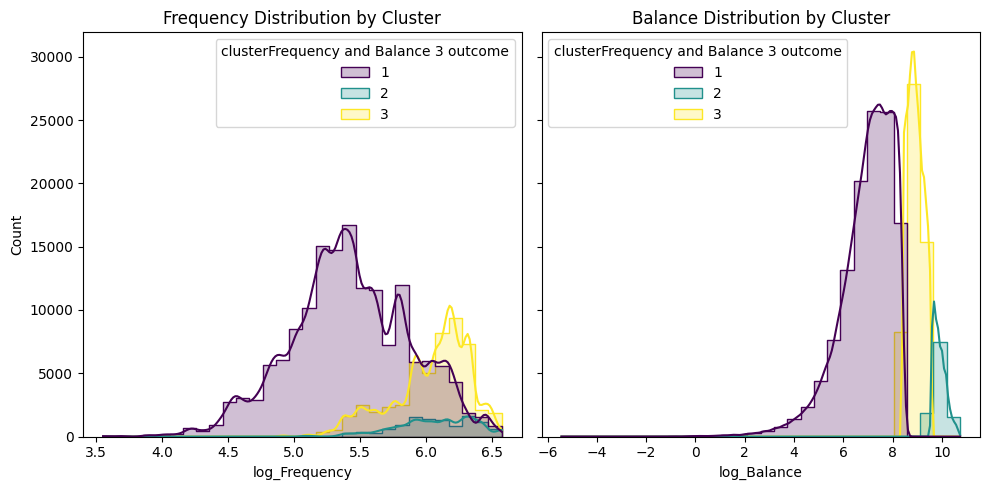

Customer Distribution Percentage:
clusterFrequency and Balance 3 outcome
1    71.508921
3    23.541389
2     4.949690
Name: proportion, dtype: float64
Cluster 1: 71.51%
Cluster 2: 4.95%
Cluster 3: 23.54%
            Percentage
Category              
Numeric      35.253140
healthcare   16.622369
art           9.393264
clothing      9.333962
finance       8.234378
               Percentage
Category                 
Tesco           31.698409
Sports Direct   15.084166
Topshop          8.435012
PureGym          7.929211
Fat Face         7.591626
              Percentage
Category                
grocery        21.705102
clothing       17.924819
gaming         12.080321
sport          10.395778
subscription    9.890690


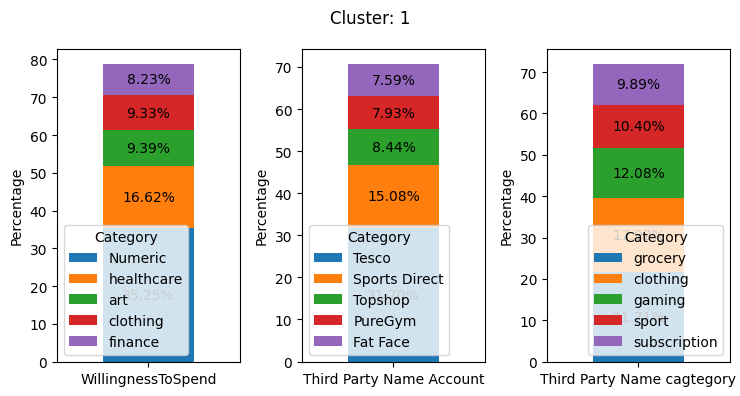

            Percentage
Category              
finance      42.372256
healthcare   29.118244
education    17.708910
clothing      5.128205
department    1.807785
           Percentage
Category             
JustEat     16.849941
Tesco       15.530367
Deliveroo   14.785992
Amazon      10.573507
Topshop      8.424970
              Percentage
Category                
clothing       23.642785
delivery       18.869828
grocery        17.436932
subscription   11.806256
art             6.569122


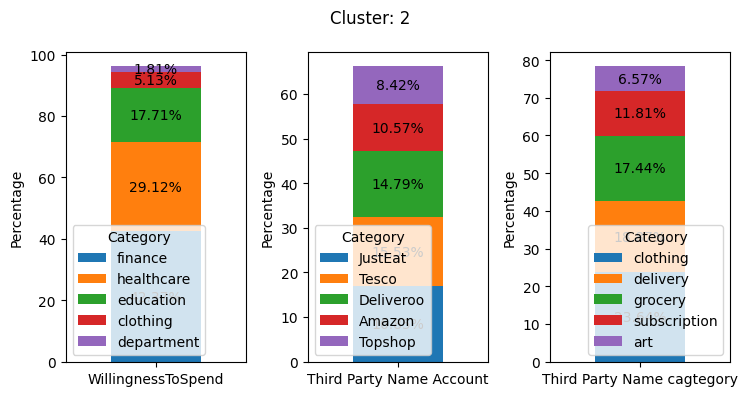

            Percentage
Category              
finance      29.608217
healthcare   23.205609
clothing     12.245526
education     9.483978
pet           6.658876
               Percentage
Category                 
Tesco           20.563130
Amazon          10.702561
JustEat         10.327913
Deliveroo       10.239079
Sports Direct   10.146383
              Percentage
Category                
clothing       23.903276
grocery        19.507905
subscription   11.819184
delivery       11.285127
art             8.523715


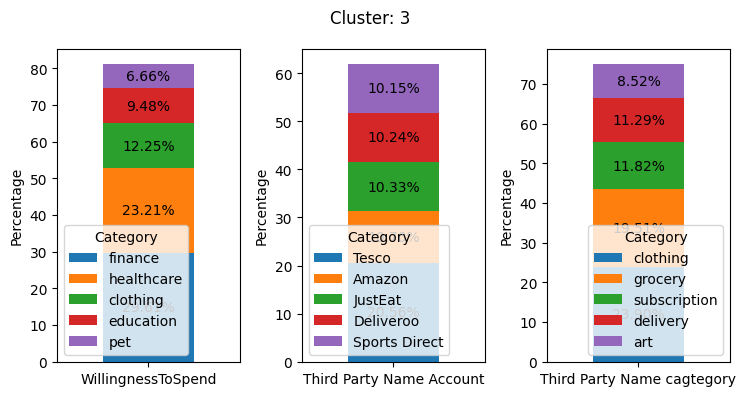

In [35]:
## criteria [ low balance but high frequency -> low balance but high spending]
## balance, frequency -> MonetaryValue

## midium balance have midium spending freqency 
# highest balance have -> not the only most often spending 
# lowest balance have -> all range of spending behavior
function_run_all(outgoing_payments,"Frequency and Balance 3 outcome",['Frequency','Balance'],3,'Frequency','Balance','second dataset')  ##note



#### MonetaryValue VS Amount Cluster 3

MonetaryValue and MoneyTransferAmount 3 outcome
Silhouette score: 0.5459434844454834


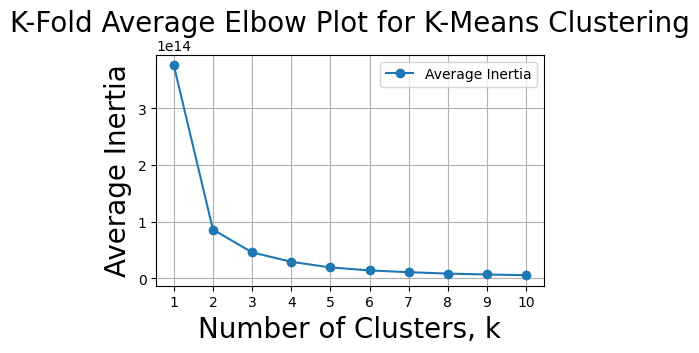

                                                    MonetaryValue  \
clusterMonetaryValue and MoneyTransferAmount 3 ...                  
1                                                    17029.085352   
2                                                    32585.890253   
3                                                    22922.349305   

                                                    MoneyTransferAmount  
clusterMonetaryValue and MoneyTransferAmount 3 ...                       
1                                                             14.269374  
2                                                             25.462617  
3                                                             17.359524  


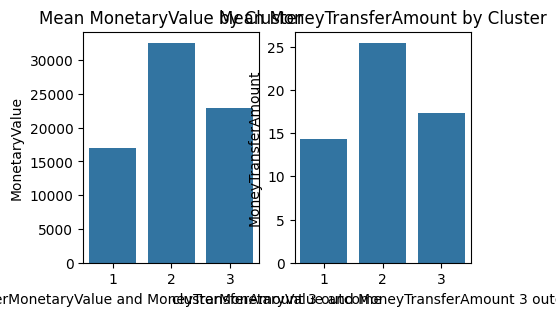

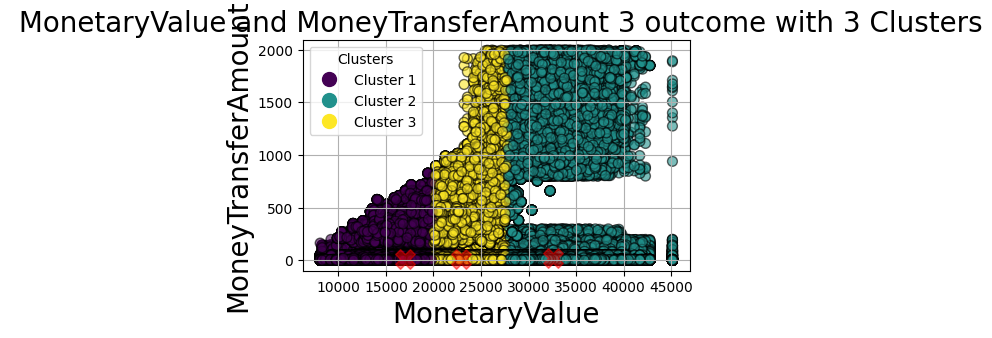

/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = gr

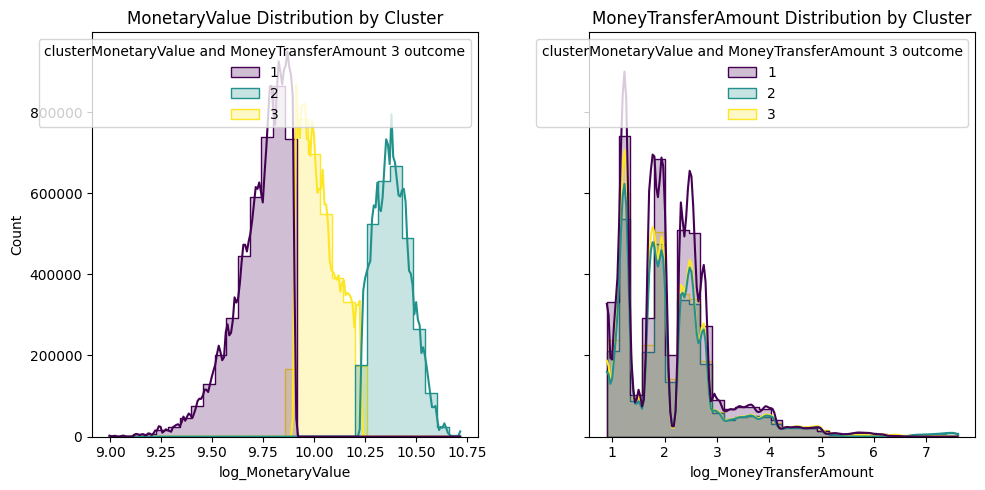

Customer Distribution Percentage:
clusterMonetaryValue and MoneyTransferAmount 3 outcome
1    41.113992
3    30.446933
2    28.439075
Name: proportion, dtype: float64
Cluster 1: 41.11%
Cluster 2: 28.44%
Cluster 3: 30.45%
            Percentage
Category              
CLOTHING     50.003046
GROCERY      22.555913
ELECTRONIC   15.600036
HEALTH        5.371065
KIDS          3.959450
                            Percentage
Category                              
PUB                          18.060163
BAR                          16.705574
LOCAL_WATERING_HOLE          14.076851
TOTALLY_A_REAL_COFFEE_SHOP    9.685860
A_CAFE                        9.643228
            Percentage
Category              
BAR          29.282976
Numeric      26.518443
COFFEE       25.183501
LUNCH         4.929065
RESTAURANT    3.318119


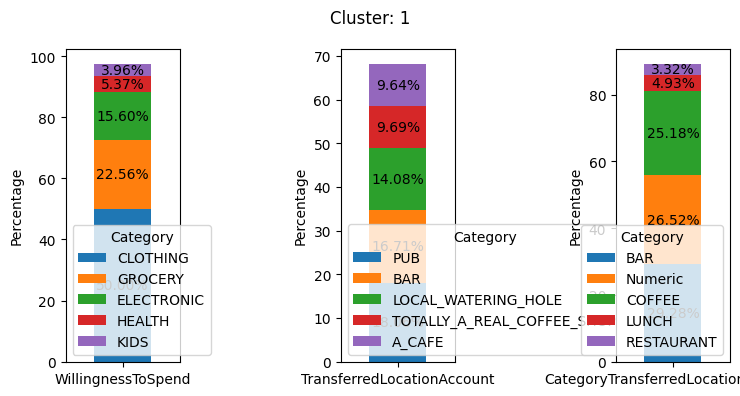

            Percentage
Category              
CLOTHING     53.681173
ELECTRONIC   16.653956
GROCERY      14.886228
Numeric       9.478437
HEALTH        3.043335
                            Percentage
Category                              
PUB                          16.955322
BAR                          15.601164
LOCAL_WATERING_HOLE          13.237880
COFFEE_SHOP                   9.842989
TOTALLY_A_REAL_COFFEE_SHOP    9.794311
             Percentage
Category               
BAR           27.280848
COFFEE        26.671259
Numeric       25.401888
LUNCH          6.028582
SUPERMARKET    3.604225


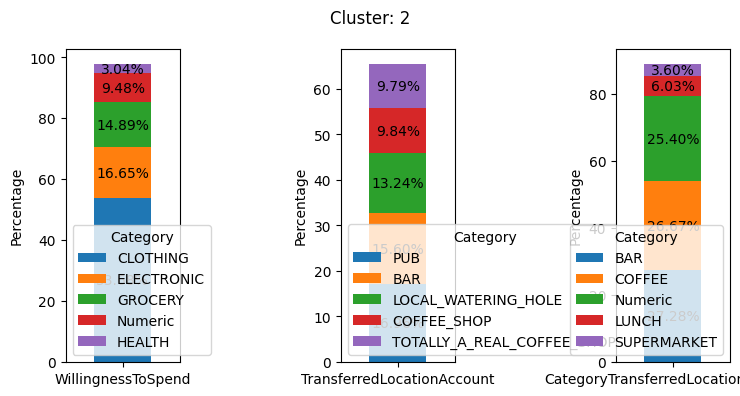

            Percentage
Category              
CLOTHING     59.752511
ELECTRONIC   17.243579
GROCERY      13.268713
HEALTH        3.673265
Numeric       2.915005
                     Percentage
Category                       
PUB                   16.243362
BAR                   15.008114
LOCAL_WATERING_HOLE   12.551983
COFFEE_SHOP           10.008377
A_CAFE                10.007365
             Percentage
Category               
COFFEE        27.917383
BAR           26.656515
Numeric       25.059019
LUNCH          6.285846
SUPERMARKET    3.559192


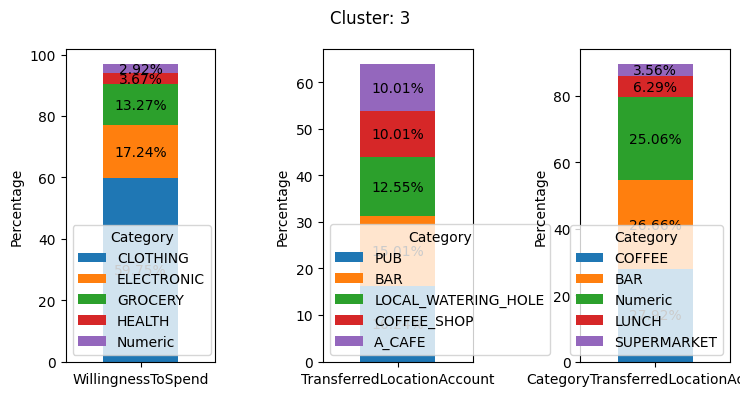

In [36]:
function_run_all(dataset1_merged_df,"MonetaryValue and MoneyTransferAmount 3 outcome",['MonetaryValue','MoneyTransferAmount'],3,'MonetaryValue','MoneyTransferAmount','first dataset')

MonetaryValue and Amount 3 outcome


Silhouette score: 0.6633612210492147


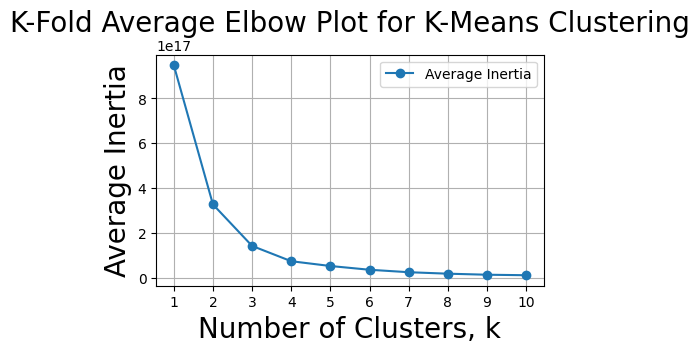

                                           MonetaryValue     Amount
clusterMonetaryValue and Amount 3 outcome                          
1                                           4.166152e+05 -93.452316
2                                           3.790778e+06 -57.633827
3                                           1.045859e+07 -54.653840


/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/1861835148.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'+str(txt)] = model.fit_predict(X) +1


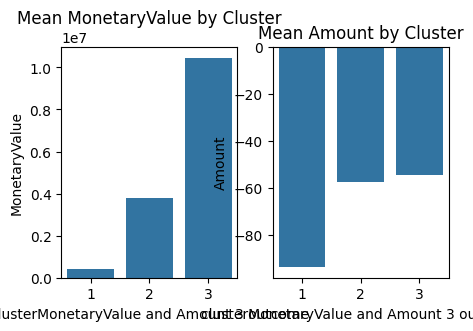

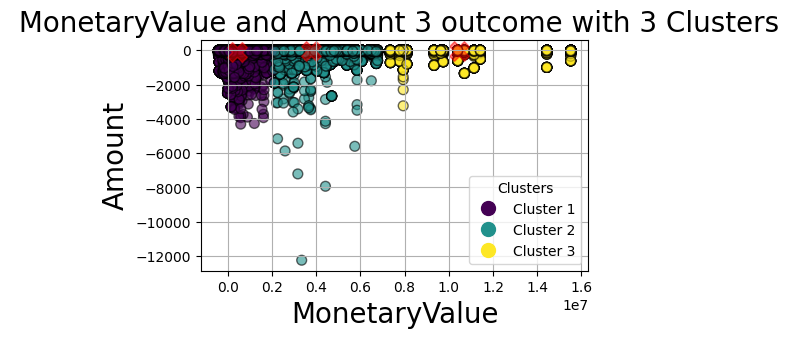

/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pand

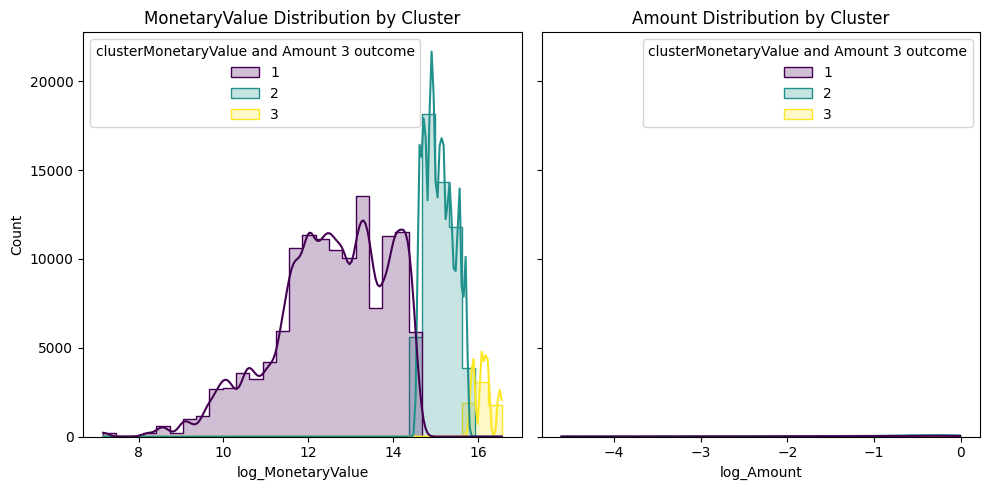

Customer Distribution Percentage:
clusterMonetaryValue and Amount 3 outcome
1    72.390022
2    24.532057
3     3.077920
Name: proportion, dtype: float64
Cluster 1: 72.39%
Cluster 2: 24.53%
Cluster 3: 3.08%
            Percentage
Category              
Numeric      34.532028
healthcare   16.947007
art          10.248557
clothing      9.598517
finance       7.491371
               Percentage
Category                 
Tesco           30.984748
Sports Direct   15.010278
Topshop          8.608452
PureGym          8.090582
Fat Face         7.671516
              Percentage
Category                
grocery        21.515645
clothing       18.347248
gaming         11.974479
sport          10.388244
subscription   10.283717


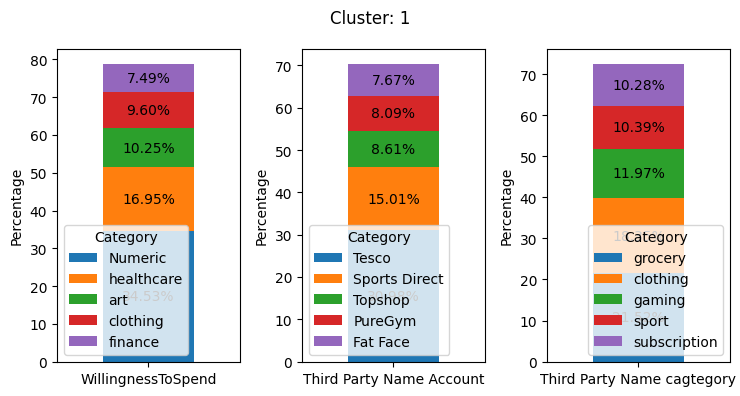

            Percentage
Category              
finance      34.127478
healthcare   22.695297
clothing     10.909444
education     8.789351
pet           5.961912
               Percentage
Category                 
Tesco           20.927708
JustEat         11.636153
Deliveroo       11.306896
Amazon          10.036906
Sports Direct    9.609957
              Percentage
Category                
clothing       22.726997
grocery        19.782552
delivery       12.814502
subscription   10.852212
art             8.758564


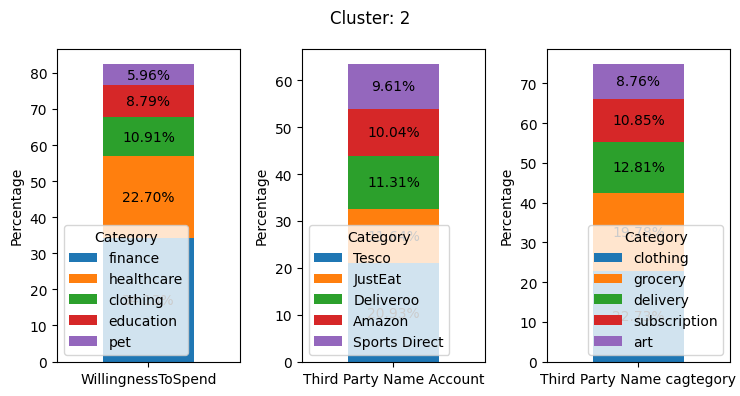

            Percentage
Category              
finance      35.716405
healthcare   31.192524
education    27.024622
clothing      6.066449
           Percentage
Category             
Tesco       18.198675
JustEat     14.701987
Deliveroo   12.370861
Amazon       9.377483
              Percentage
Category                
clothing       24.469821
grocery        18.205546
delivery       16.672104
subscription   10.734095


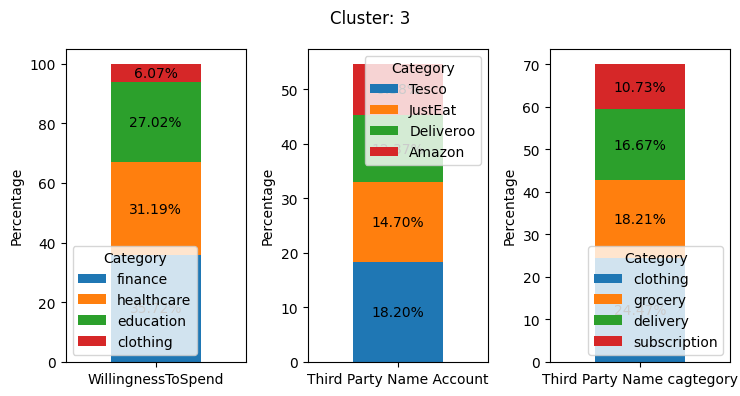

In [37]:

function_run_all(outgoing_payments,"MonetaryValue and Amount 3 outcome",['MonetaryValue','Amount'],3,'MonetaryValue','Amount','second dataset') ##note

#### MonetaryValue VS Balance Cluster 3

MonetaryValue and Balance 3 outcome
Silhouette score: 0.6572294976964115


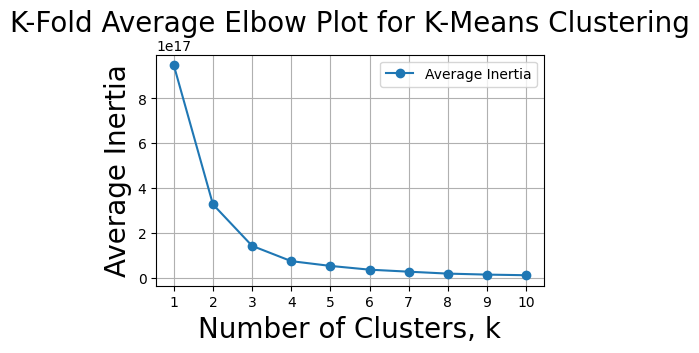

                                            MonetaryValue       Balance
clusterMonetaryValue and Balance 3 outcome                             
1                                            4.166152e+05   1284.836816
2                                            3.790778e+06   8511.487915
3                                            1.045859e+07  19352.679469


/var/folders/__/6m3ls1tn1m5btytc8x1n4_j40000gn/T/ipykernel_4509/1861835148.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'+str(txt)] = model.fit_predict(X) +1


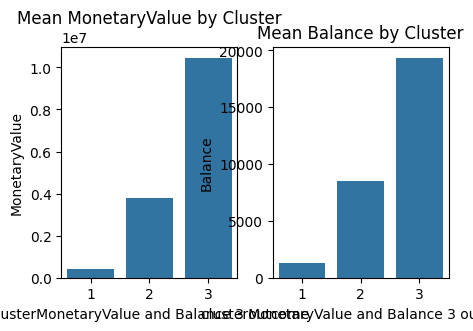

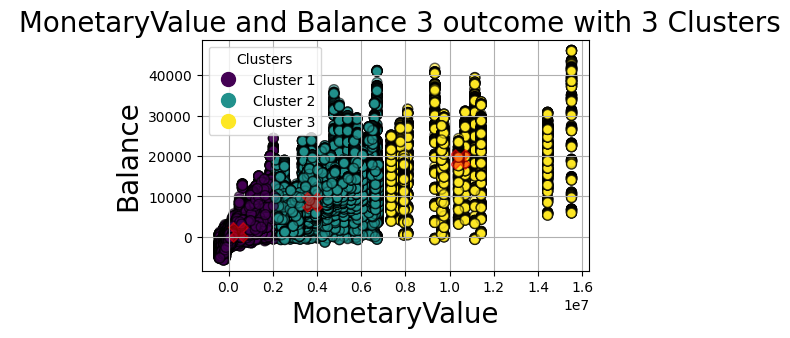

/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/thanaparleelasathapornkun/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: Futu

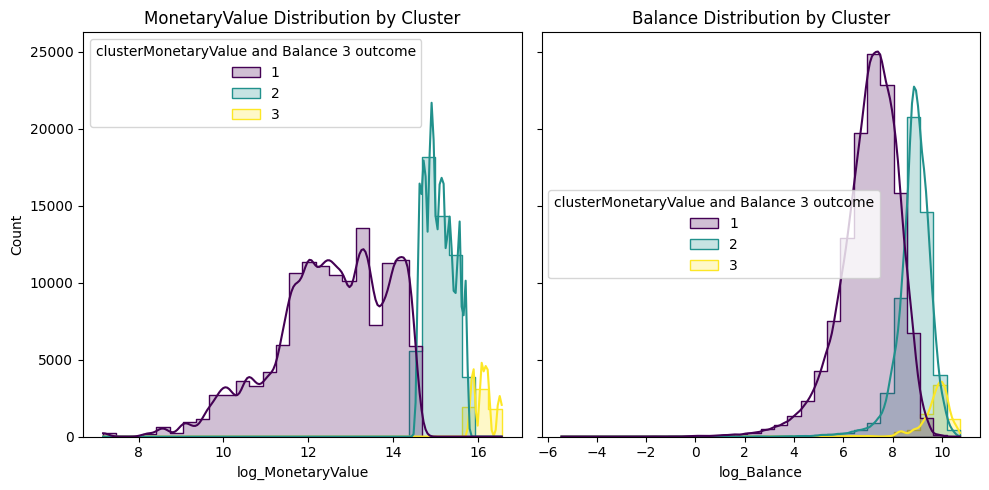

Customer Distribution Percentage:
clusterMonetaryValue and Balance 3 outcome
1    72.390022
2    24.532057
3     3.077920
Name: proportion, dtype: float64
Cluster 1: 72.39%
Cluster 2: 24.53%
Cluster 3: 3.08%
            Percentage
Category              
Numeric      34.532028
healthcare   16.947007
art          10.248557
clothing      9.598517
finance       7.491371
               Percentage
Category                 
Tesco           30.984748
Sports Direct   15.010278
Topshop          8.608452
PureGym          8.090582
Fat Face         7.671516
              Percentage
Category                
grocery        21.515645
clothing       18.347248
gaming         11.974479
sport          10.388244
subscription   10.283717


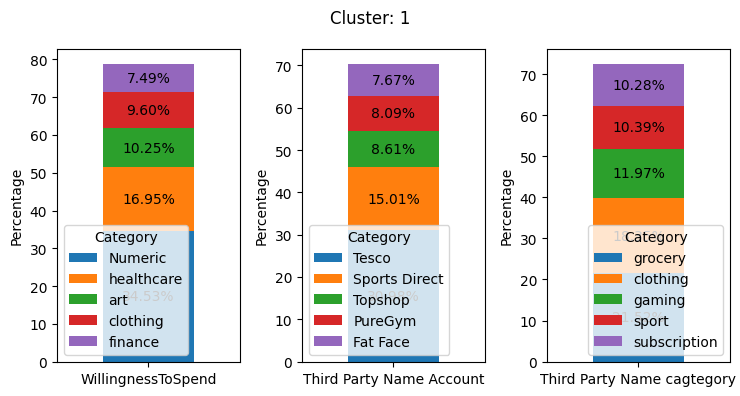

            Percentage
Category              
finance      34.127478
healthcare   22.695297
clothing     10.909444
education     8.789351
pet           5.961912
               Percentage
Category                 
Tesco           20.927708
JustEat         11.636153
Deliveroo       11.306896
Amazon          10.036906
Sports Direct    9.609957
              Percentage
Category                
clothing       22.726997
grocery        19.782552
delivery       12.814502
subscription   10.852212
art             8.758564


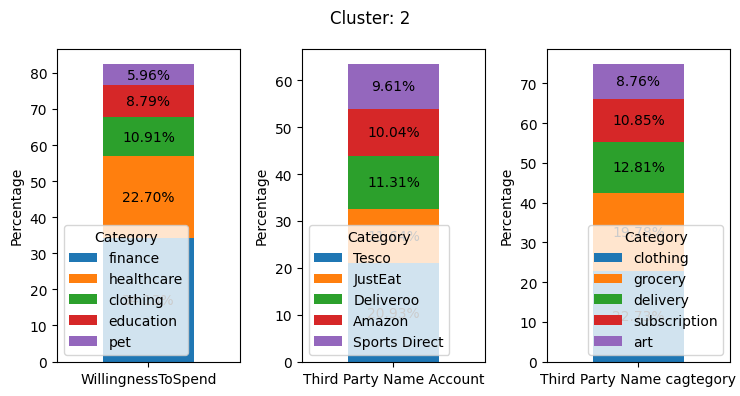

            Percentage
Category              
finance      35.716405
healthcare   31.192524
education    27.024622
clothing      6.066449
           Percentage
Category             
Tesco       18.198675
JustEat     14.701987
Deliveroo   12.370861
Amazon       9.377483
              Percentage
Category                
clothing       24.469821
grocery        18.205546
delivery       16.672104
subscription   10.734095


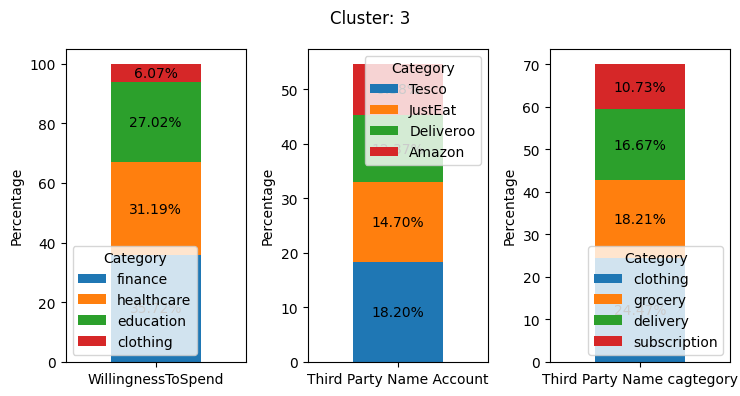

In [38]:
function_run_all(outgoing_payments,"MonetaryValue and Balance 3 outcome",['MonetaryValue','Balance'],3,'MonetaryValue','Balance','second dataset') ##note